<a href="https://colab.research.google.com/github/abhiramoggu/statistics-analysis/blob/main/STATFinalQ1v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

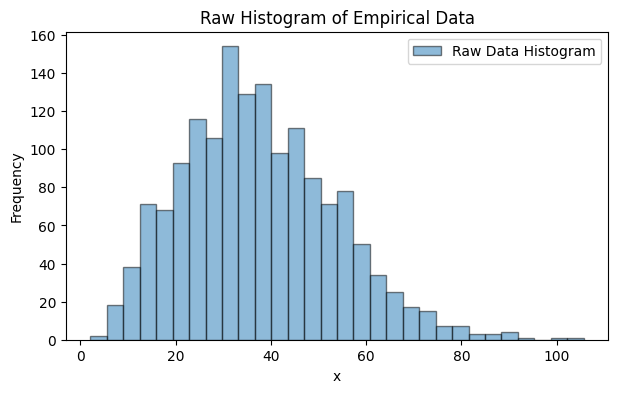

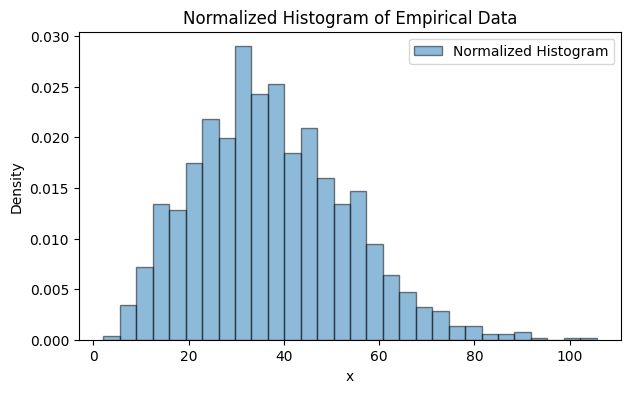

Data loaded. Number of points = 1540
Improved PDFs defined.
NLL functions + gradient fits for all 10 models (no multi-start).
Simulated Annealing defined.
Hybrid approach (SA + gradient) defined.

Optimizing Model #1...
  Gradient: Best Params=[ 0.50350701 33.1689246 ], NLL=6503.951038
  Annealing: Best Params=[ 0.5 33. ], NLL=6504.112953
  Hybrid:   Best Params=[ 0.5035072  33.16918117], NLL=6503.951038

Optimizing Model #2...
  Gradient: Best Params=[ 6.08352902  0.37905604 48.08731038], NLL=6416.247894
  Annealing: Best Params=[ 5.58236606  0.16696712 99.51683467], NLL=7116.317468
  Hybrid:   Best Params=[ 6.08338597  0.37906892 48.08701243], NLL=6416.247894

Optimizing Model #3...
  Gradient: Best Params=[37.33459699 16.14319511], NLL=6443.366142
  Annealing: Best Params=[37.38015174 16.13062584], NLL=6443.372951
  Hybrid:   Best Params=[37.33425554 16.14295791], NLL=6443.366142

Optimizing Model #4...
  Gradient: Best Params=[ 1.669451   26.13244887], NLL=6826.841013
  Annealing: 

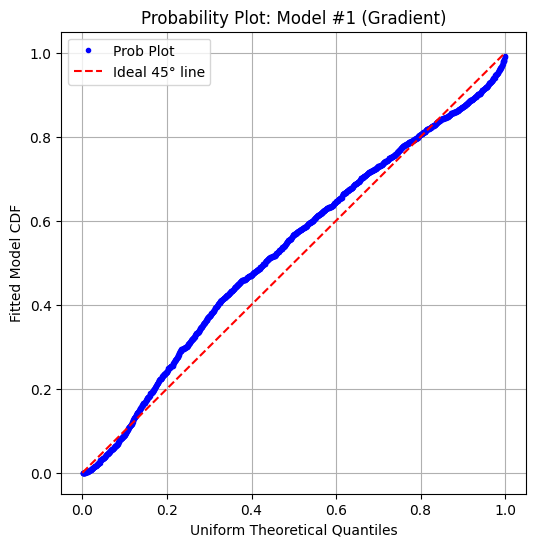

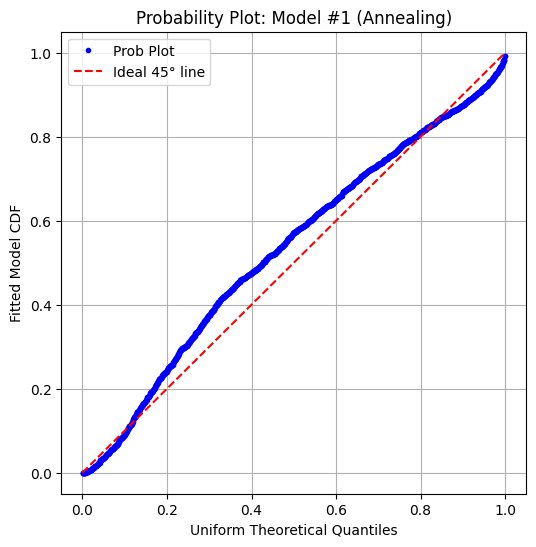

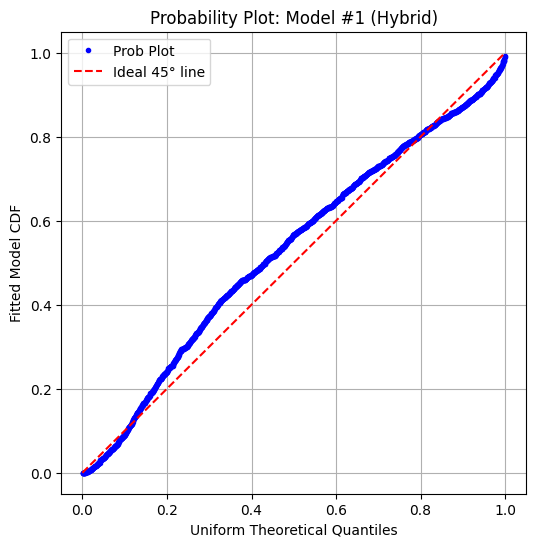

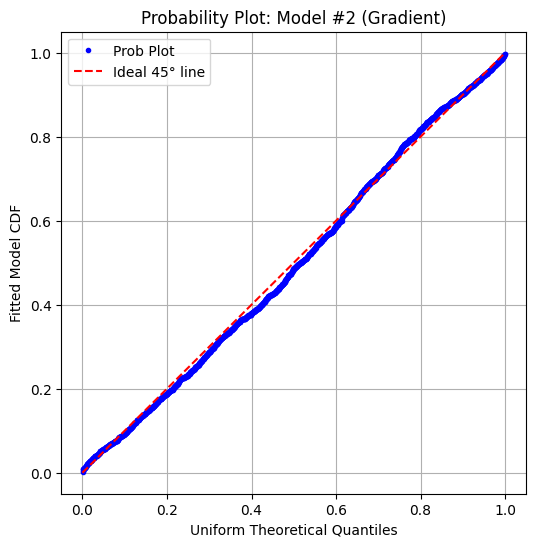

<ipython-input-2-a89d650397ab>:70: RuntimeWarning: divide by zero encountered in scalar power
  numerator = (c * k / (b ** (c * k))) * (x ** (c * k - 1.0))


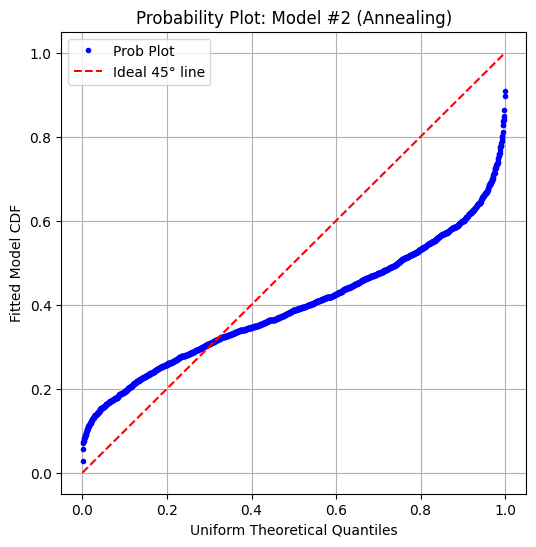

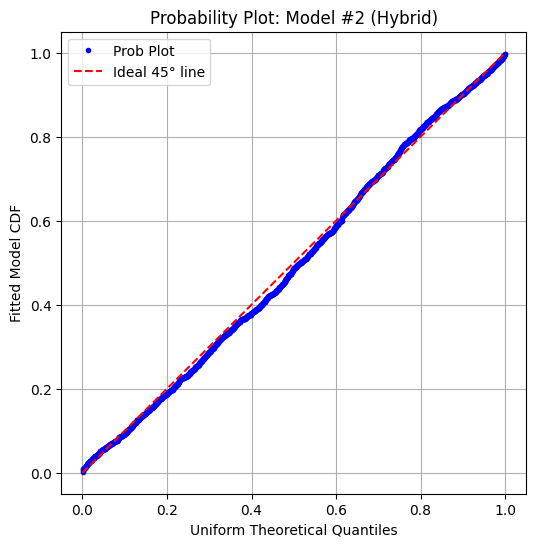

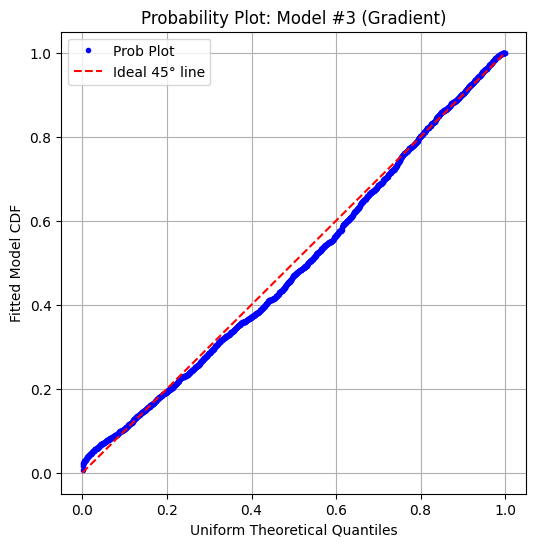

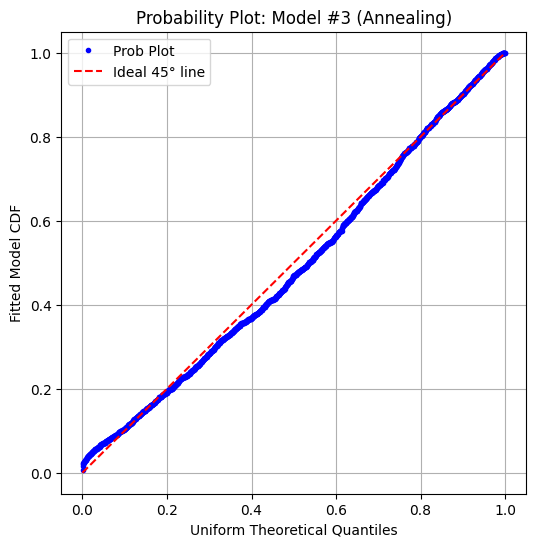

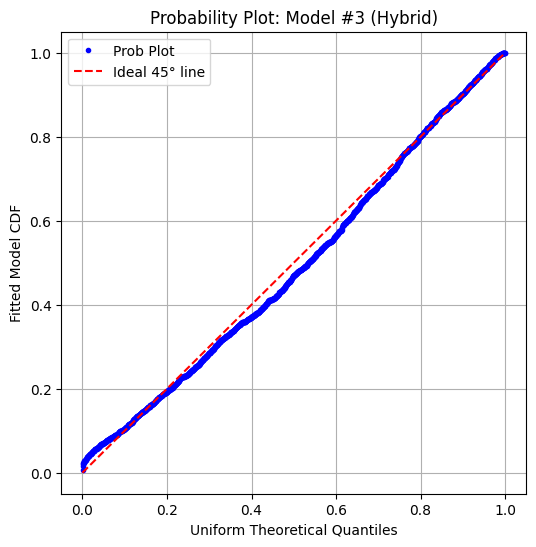

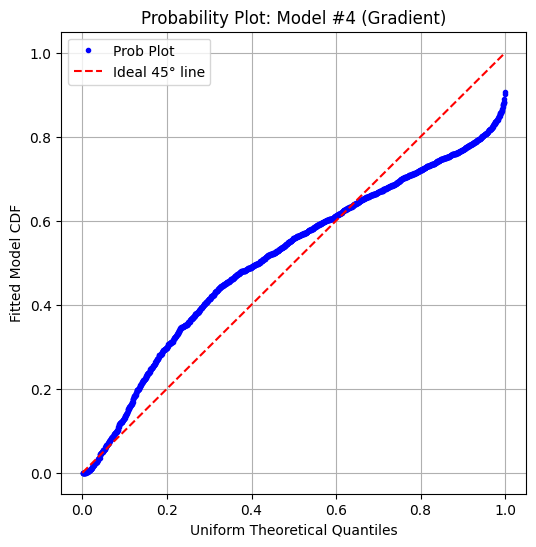

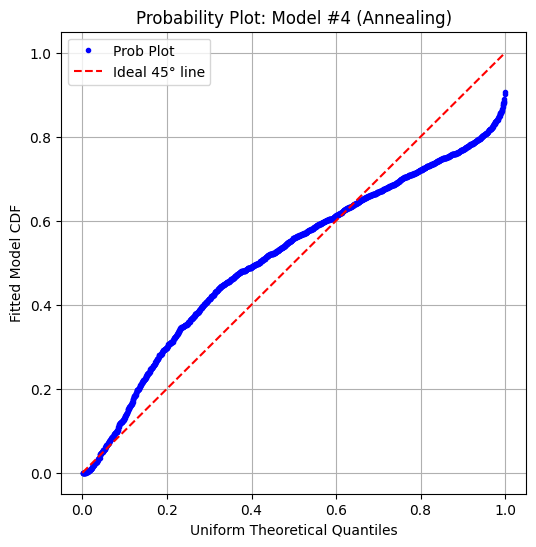

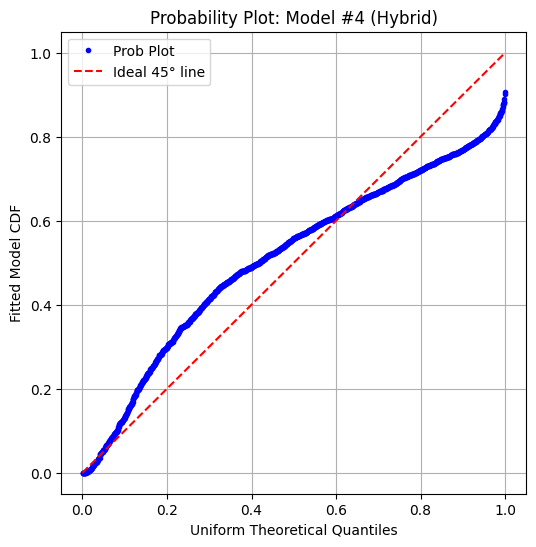

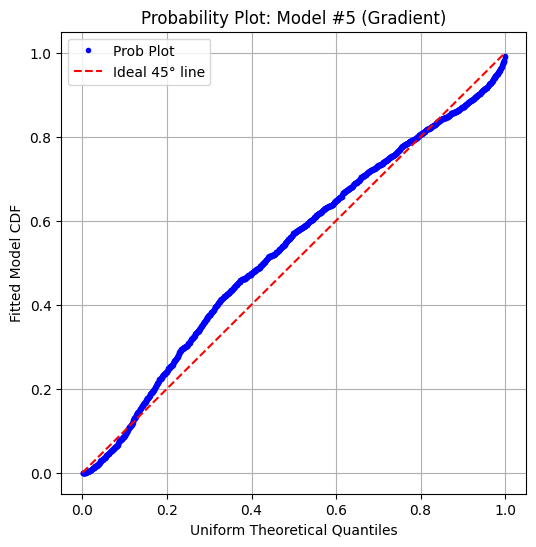

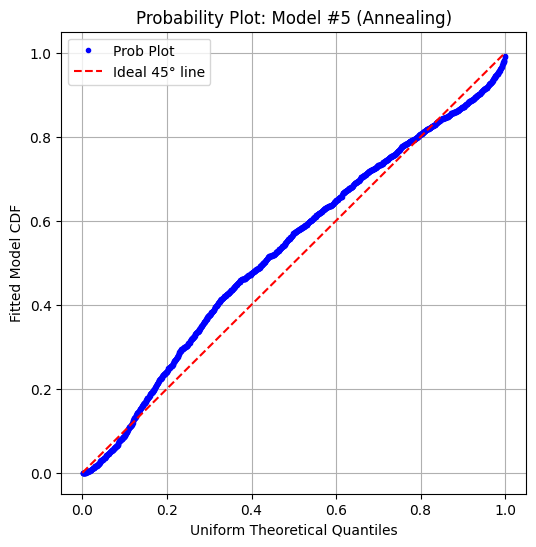

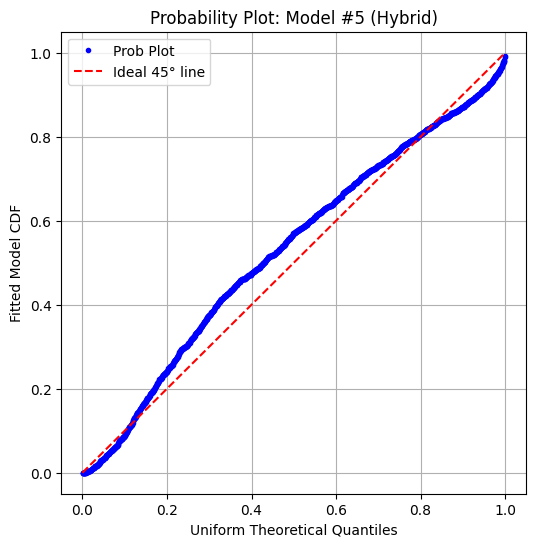

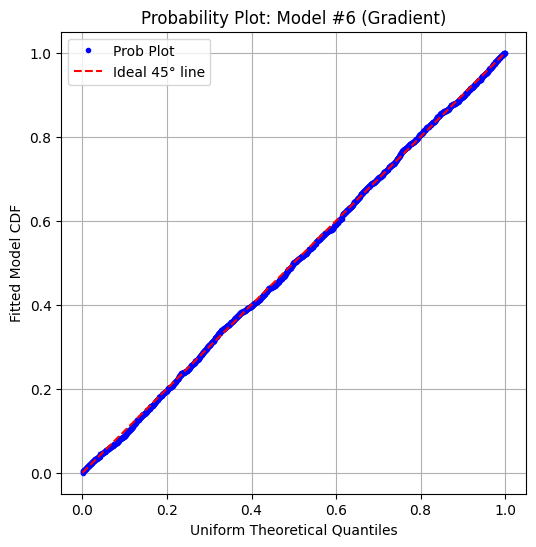

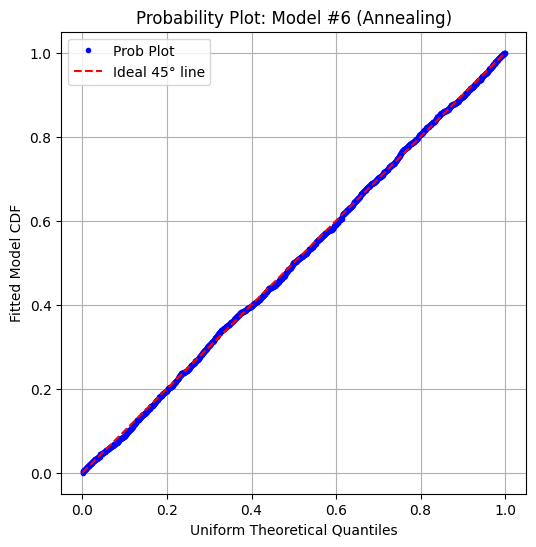

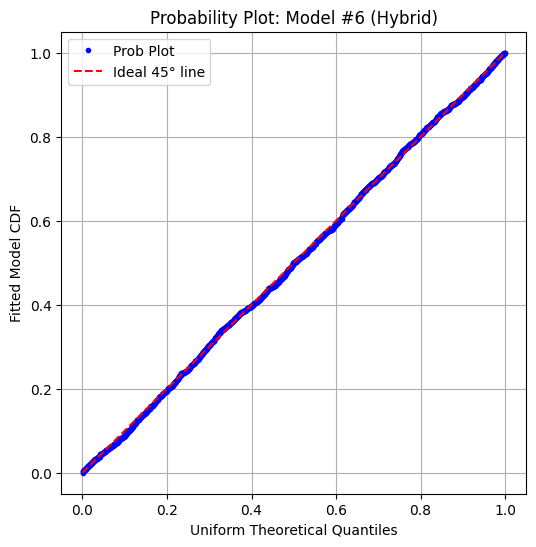

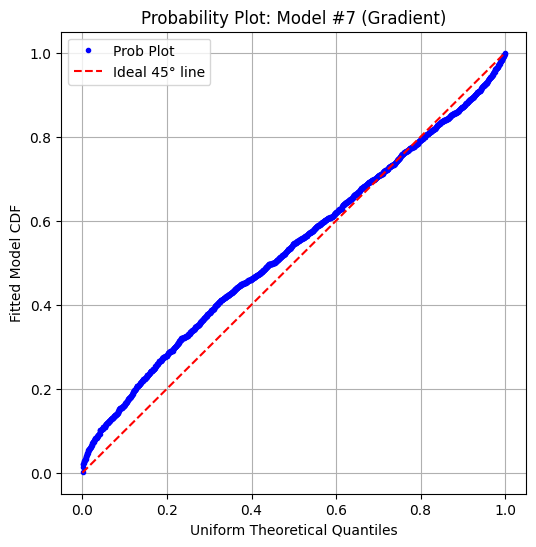

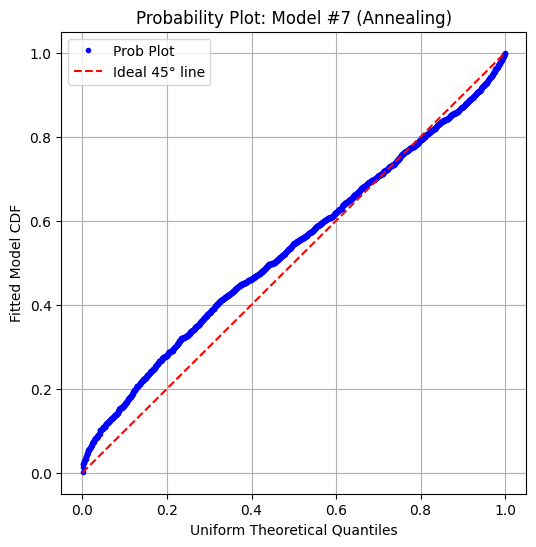

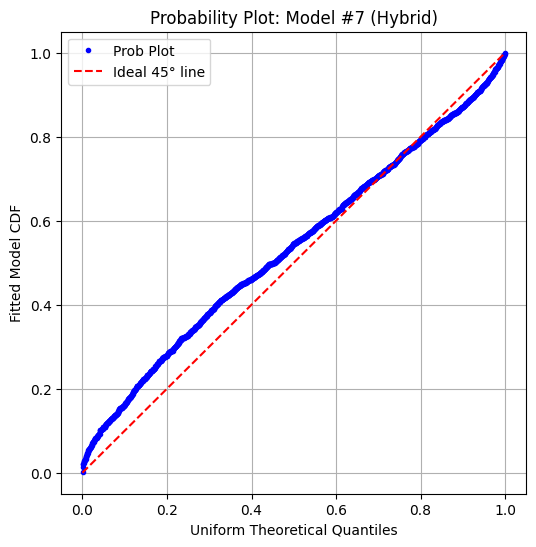

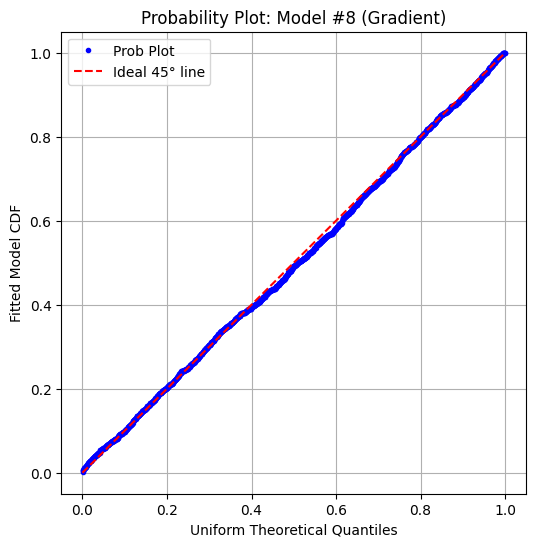

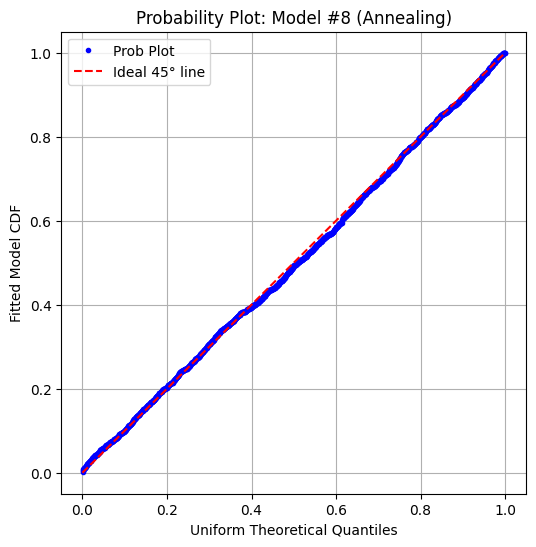

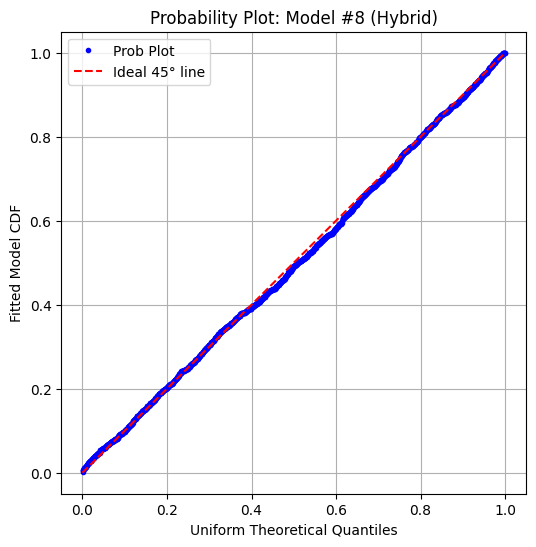

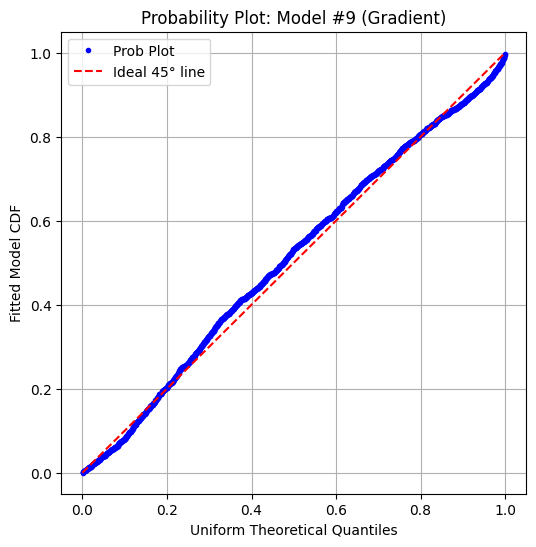

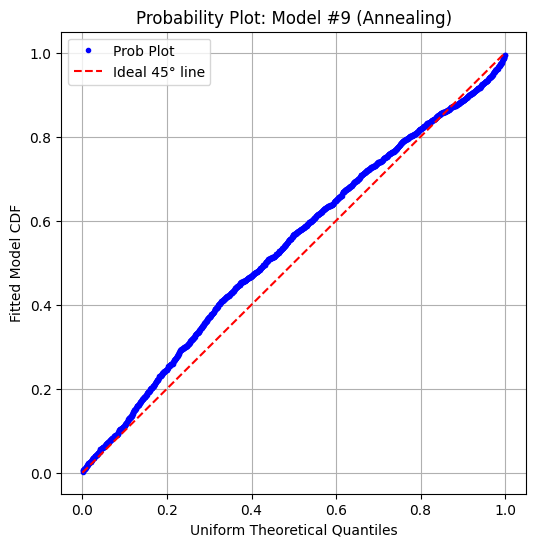

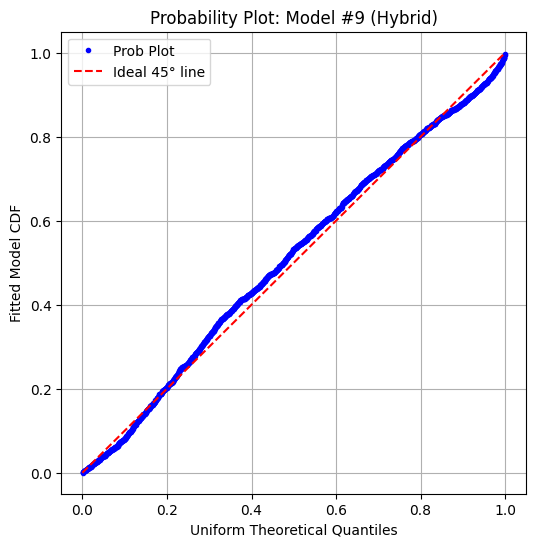

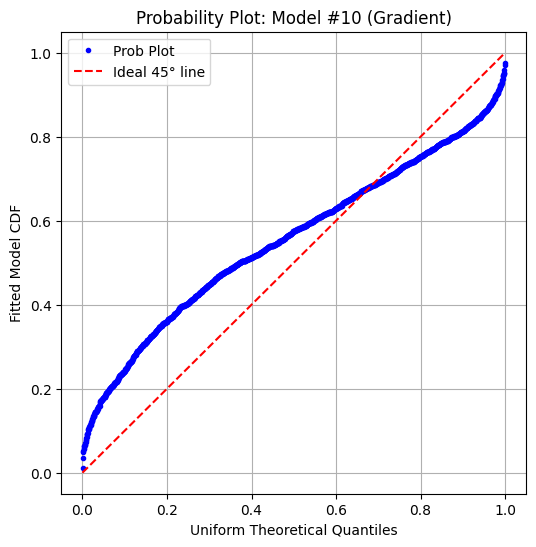

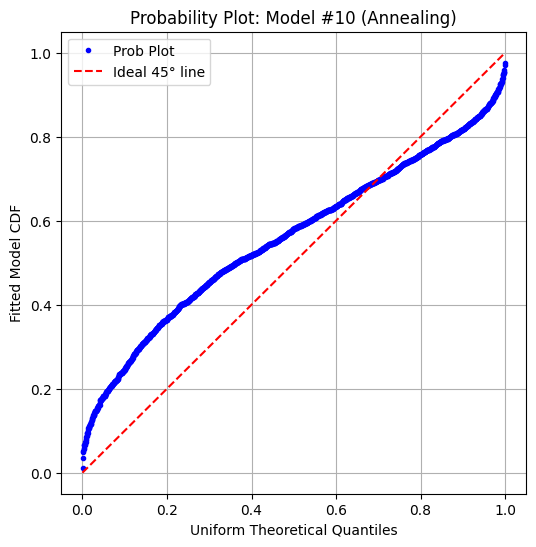

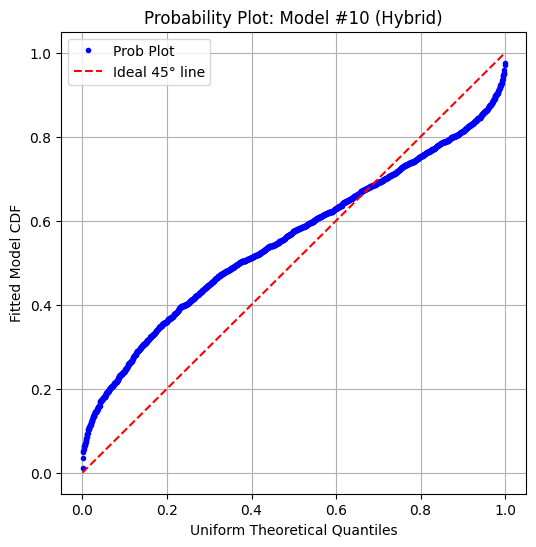

Plotted Probability Plots for all three methods, each for 10 models.

=== KS TEST RESULTS ===
Model #1 (gradient): KS stat=0.0820, p-value=0.0000, => REJECT at alpha=0.05
Model #1 (annealing): KS stat=0.0854, p-value=0.0000, => REJECT at alpha=0.05
Model #1 (hybrid): KS stat=0.0820, p-value=0.0000, => REJECT at alpha=0.05
Model #2 (gradient): KS stat=0.0280, p-value=0.1775, => FAIL TO REJECT at alpha=0.05
Model #2 (annealing): KS stat=0.3026, p-value=0.0000, => REJECT at alpha=0.05
Model #2 (hybrid): KS stat=0.0280, p-value=0.1775, => FAIL TO REJECT at alpha=0.05
Model #3 (gradient): KS stat=0.0402, p-value=0.0139, => REJECT at alpha=0.05
Model #3 (annealing): KS stat=0.0413, p-value=0.0103, => REJECT at alpha=0.05
Model #3 (hybrid): KS stat=0.0402, p-value=0.0139, => REJECT at alpha=0.05
Model #4 (gradient): KS stat=0.1490, p-value=0.0000, => REJECT at alpha=0.05
Model #4 (annealing): KS stat=0.1487, p-value=0.0000, => REJECT at alpha=0.05
Model #4 (hybrid): KS stat=0.1490, p-value=0.

In [ ]:
##############################################
# 0. IMPORTS & DATA LOADING
##############################################
import csv
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# For reproducibility in random sampling, etc.
random.seed(123)
np.random.seed(123)

##############################################
# 1. LOAD DATA + PLOT HISTOGRAMS
##############################################
data_file = "data26002204680.csv"  # your CSV file path
data = []
with open(data_file, "r") as f:
    reader = csv.reader(f)
    for row in reader:
        try:
            val = float(row[0])
            data.append(val)
        except ValueError:
            continue  # Skip rows that don't contain valid floats

data = np.array(data)
n = len(data)

# 1A. RAW HISTOGRAM
plt.figure(figsize=(7, 4))
plt.hist(data, bins=30, alpha=0.5, edgecolor='k', label="Raw Data Histogram")
plt.title("Raw Histogram of Empirical Data")
plt.xlabel("x")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 1B. NORMALIZED HISTOGRAM (counts / total => a PDF-like shape)
plt.figure(figsize=(7, 4))
plt.hist(data, bins=30, density=True, alpha=0.5, edgecolor='k', label="Normalized Histogram")
plt.title("Normalized Histogram of Empirical Data")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

print(f"Data loaded. Number of points = {n}")

##############################################
# 2. DEFINE THE 10 CANDIDATE PDFS (Improved)
##############################################
def pdf1(x, alpha, beta):
    if alpha <= 0 or beta <= 0 or x <= 0:
        return 1e-10
    try:
        denom = 2.0 * alpha * math.sqrt(2.0 * math.pi * beta) * (x ** 1.5)
        exponent = -((x - beta) ** 2) / (2.0 * (alpha ** 2) * beta * x)
        val = (math.exp(exponent) * (x + beta)) / denom
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf2(x, c, k, b):
    if x < 0 or c <= 0 or k <= 0 or b <= 0:
        return 1e-10
    try:
        numerator = (c * k / (b ** (c * k))) * (x ** (c * k - 1.0))
        denominator = (1.0 + (x ** c) / (b ** c)) ** (k + 1.0)
        if denominator <= 0 or math.isinf(numerator) or math.isinf(denominator):
            return 1e-10
        val = numerator / denominator
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf3(x, mu, sigma):
    if sigma <= 0 or x < 0:
        return 1e-10
    try:
        coeff = 1.0 / (sigma * math.sqrt(2.0 * math.pi))
        term1 = math.exp(-((x - mu) ** 2) / (2.0 * sigma ** 2))
        term2 = math.exp(-((x + mu) ** 2) / (2.0 * sigma ** 2))
        val = coeff * (term1 + term2)
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf4(x, c, sigma):
    if x <= 0 or c <= 0 or sigma <= 0:
        return 1e-10
    try:
        val = (c / x) * ((x / sigma) ** (-c)) * math.exp(-((x / sigma) ** (-c)))
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf5(x, lam, mu):
    if x <= 0 or lam <= 0 or mu <= 0:
        return 1e-10
    try:
        coeff = math.sqrt(lam / (2.0 * math.pi * (x ** 3)))
        exponent = - lam * ((x - mu) ** 2) / (2.0 * (mu ** 2) * x)
        val = coeff * math.exp(exponent)
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf6(x, sigma):
    if x < 0 or sigma <= 0:
        return 1e-10
    try:
        factor = math.sqrt(2.0 / math.pi) * (x ** 2) / (sigma ** 3)
        val = factor * math.exp(-(x ** 2) / (2.0 * sigma ** 2))
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf7(x, sigma):
    if x < 0 or sigma <= 0:
        return 1e-10
    try:
        val = (x / (sigma ** 2)) * math.exp(-(x ** 2) / (2.0 * sigma ** 2))
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf8(x, c, b):
    if x < 0 or c <= 0 or b <= 0:
        return 1e-10
    try:
        val = (c * (x ** (c - 1.0)) * math.exp(-((x ** c) / (b ** c)))) / (b ** c)
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf9(x, lam, mu):
    if x < 0 or lam <= 0 or mu <= 0:
        return 1e-10
    try:
        expr1 = math.exp(-x * lam)
        expr2 = expr1 * mu
        val = math.exp(-x * lam - expr2)
        bracket = lam * (1.0 + (1.0 - expr1) * mu)
        result = val * bracket
        return result if result > 0 and not math.isnan(result) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf10(x, sigma):
    if x < 0 or sigma <= 0:
        return 1e-10
    try:
        const = ((sigma ** 2) * (1.0 + x)) / (1.0 + sigma)
        exponent = -x * sigma
        val = const * math.exp(exponent)
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

print("Improved PDFs defined.")

##############################################
# 3. NLL AND BASIC FIT (Gradient-based) FOR ALL MODELS
##############################################
def nll_1(params, data_array):
    alpha, beta = params
    if alpha <= 0 or beta <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf1(x, alpha, beta)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf1_gradient(data_array):
    init = [0.5, 33.0]
    bnds = [(1e-6, None), (1e-6, None)]  # No explicit upper bound
    res = minimize(lambda p: nll_1(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_2(params, data_array):
    c_, k_, b_ = params
    if c_ <= 0 or k_ <= 0 or b_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf2(x, c_, k_, b_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf2_gradient(data_array):
    init = [1.0, 1.5, 100.0]
    bnds = [(1e-6, None), (1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_2(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_3(params, data_array):
    mu_, sigma_ = params
    if sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf3(x, mu_, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf3_gradient(data_array):
    init = [3.0, 9.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_3(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_4(params, data_array):
    c_, sigma_ = params
    if c_ <= 0 or sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf4(x, c_, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf4_gradient(data_array):
    init = [4.0, 9.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_4(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_5(params, data_array):
    lam_, mu_ = params
    if lam_ <= 0 or mu_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf5(x, lam_, mu_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf5_gradient(data_array):
    init = [3.0, 10.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_5(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_6(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf6(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf6_gradient(data_array):
    init = [4.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_6(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_7(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf7(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf7_gradient(data_array):
    init = [3.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_7(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_8(params, data_array):
    c_, b_ = params
    if c_ <= 0 or b_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf8(x, c_, b_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf8_gradient(data_array):
    init = [1.0, 1.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_8(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_9(params, data_array):
    lam_, mu_ = params
    if lam_ <= 0 or mu_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf9(x, lam_, mu_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf9_gradient(data_array):
    init = [6.0, 3.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_9(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_10(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf10(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf10_gradient(data_array):
    init = [3.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_10(p, data_array), init, bounds=bnds, options={'maxiter':1000})
    return res.x, res.fun

print("NLL functions + gradient fits for all 10 models (no multi-start).")

##############################################
# 4. SIMULATED ANNEALING (SA)
##############################################
def simulated_annealing(nll_func, init_params, data_array,
                        max_iter=2000, temp_start=10.0, temp_end=0.1, alpha=0.99):
    """
    Simple Simulated Annealing (SA) approach.
    """
    import copy

    current_params = np.array(init_params, dtype=np.float64)
    current_nll = nll_func(current_params, data_array)
    best_params = copy.deepcopy(current_params)
    best_nll = current_nll

    temp = temp_start

    for i in range(max_iter):
        candidate = current_params + np.random.normal(0, 1, size=len(current_params))
        # Clip positivity
        candidate = np.clip(candidate, 1e-6, 1e9)

        cand_nll = nll_func(candidate, data_array)

        if cand_nll < current_nll:
            current_params = candidate
            current_nll = cand_nll
            if cand_nll < best_nll:
                best_params = candidate
                best_nll = cand_nll
        else:
            diff = cand_nll - current_nll
            prob = math.exp(-diff / temp) if temp > 0 else 0
            if np.random.rand() < prob:
                current_params = candidate
                current_nll = cand_nll

        temp = max(temp_end, temp * alpha)

    return best_params, best_nll

print("Simulated Annealing defined.")

##############################################
# 5. HYBRID (SA + Gradient)
##############################################
def fit_hybrid(nll_func, init_params, data_array):
    """
    Hybrid approach: SA followed by Gradient-based optimization.
    """
    # 1) Simulated Annealing
    sa_params, sa_nll = simulated_annealing(nll_func, init_params, data_array,
                                           max_iter=1000,
                                           temp_start=10.0, temp_end=0.01, alpha=0.98)
    # 2) Gradient-based Refinement
    param_bounds = [(1e-6, None)] * len(sa_params)
    res = minimize(lambda p: nll_func(p, data_array), sa_params, bounds=param_bounds)
    return res.x, res.fun

print("Hybrid approach (SA + gradient) defined.")

##############################################
# 6. ORGANIZE MODELS AND FITTING FUNCTIONS
##############################################
def model_nll_and_inits():
    """
    Return a dictionary:
      model_name -> (nll_function, gradient_fit_function, init_for_SA)
    We'll rely on single init param for gradient + same init for SA/hybrid.
    """
    return {
        "Model #1":  (nll_1,  fit_pdf1_gradient,  [0.5, 33.0]),
        "Model #2":  (nll_2,  fit_pdf2_gradient,  [1.0, 1.5, 100.0]),
        "Model #3":  (nll_3,  fit_pdf3_gradient,  [3.0, 9.0]),
        "Model #4":  (nll_4,  fit_pdf4_gradient,  [4.0, 9.0]),
        "Model #5":  (nll_5,  fit_pdf5_gradient,  [3.0, 10.0]),
        "Model #6":  (nll_6,  fit_pdf6_gradient,  [4.0]),
        "Model #7":  (nll_7,  fit_pdf7_gradient,  [3.0]),
        "Model #8":  (nll_8,  fit_pdf8_gradient,  [1.0, 1.0]),
        "Model #9":  (nll_9,  fit_pdf9_gradient,  [6.0, 3.0]),
        "Model #10": (nll_10, fit_pdf10_gradient, [3.0]),
    }

# Define model_fits as a list of tuples: (model_name, fit_function, number_of_parameters)
model_fits = [
    ("Model #1", fit_pdf1_gradient, 2),
    ("Model #2", fit_pdf2_gradient, 3),
    ("Model #3", fit_pdf3_gradient, 2),
    ("Model #4", fit_pdf4_gradient, 2),
    ("Model #5", fit_pdf5_gradient, 2),
    ("Model #6", fit_pdf6_gradient, 1),
    ("Model #7", fit_pdf7_gradient, 1),
    ("Model #8", fit_pdf8_gradient, 2),
    ("Model #9", fit_pdf9_gradient, 2),
    ("Model #10", fit_pdf10_gradient, 1),
]

# Initialize results dictionary and all_results list
results = {}
all_results = []
method_names = ["gradient", "annealing", "hybrid"]

# Retrieve model mapping
model_dict = model_nll_and_inits()

for (mname, fit_func, k) in model_fits:
    print(f"\nOptimizing {mname}...")
    nll_func, gradient_fit_func, init_for_SA = model_dict[mname]

    # 1) Gradient
    best_g, best_nll_g = gradient_fit_func(data)
    print(f"  Gradient: Best Params={best_g}, NLL={best_nll_g:.6f}")

    # 2) Simulated Annealing
    best_sa, best_nll_sa = simulated_annealing(nll_func, init_for_SA, data)
    print(f"  Annealing: Best Params={best_sa}, NLL={best_nll_sa:.6f}")

    # 3) Hybrid
    best_hyb, best_nll_hyb = fit_hybrid(nll_func, init_for_SA, data)
    print(f"  Hybrid:   Best Params={best_hyb}, NLL={best_nll_hyb:.6f}")

    # Store results
    results[mname] = {
        "gradient":   (best_g,   best_nll_g),
        "annealing":  (best_sa,  best_nll_sa),
        "hybrid":     (best_hyb, best_nll_hyb)
    }

    # Append to all_results for plotting and further analysis
    all_results.append(("gradient", mname, best_g, best_nll_g, k))
    all_results.append(("annealing", mname, best_sa, best_nll_sa, k))
    all_results.append(("hybrid", mname, best_hyb, best_nll_hyb, k))

print("\nAll models optimized with Gradient, Annealing, and Hybrid methods (single init).")

##############################################
# 7. PROBABILITY PLOTS
##############################################
def numeric_cdf(pdf_func, x, params, n_steps=200):
    if x <= 0:
        return 0.0
    try:
        xs = np.linspace(0, x, n_steps)
        vals = [pdf_func(xx, *params) for xx in xs]
    except TypeError as e:
        print(f"Error in numeric_cdf for x={x} with params={params}: {e}")
        return 0.0
    except Exception as e:
        print(f"Unexpected error in numeric_cdf for x={x} with params={params}: {e}")
        return 0.0

    # Replace negative or NaN values with 0 to prevent invalid areas
    vals = [v if v > 0 and not math.isnan(v) else 0.0 for v in vals]

    area = 0.0
    for i in range(n_steps - 1):
        area += 0.5 * (vals[i] + vals[i+1]) * (xs[i+1] - xs[i])
    return area

def probability_plot(method, data_array, pdf_func, params, model_name="Model"):
    sorted_data = np.sort(data_array)
    n_ = len(sorted_data)

    # Model-based CDF for each x_j
    model_cdf_vals = []
    for x_val in sorted_data:
        cdf_val = numeric_cdf(pdf_func, x_val, params)
        model_cdf_vals.append(cdf_val)

    # Compare to uniform quantiles
    uniform_q = [(i + 0.5) / n_ for i in range(n_)]

    plt.figure(figsize=(6,6))
    plt.plot(uniform_q, model_cdf_vals, 'bo', markersize=3, label='Prob Plot')
    plt.plot([0,1], [0,1], 'r--', label='Ideal 45° line')
    plt.title(f"Probability Plot: {model_name} ({method.capitalize()})")
    plt.xlabel("Uniform Theoretical Quantiles")
    plt.ylabel("Fitted Model CDF")
    plt.legend()
    plt.grid(True)
    plt.show()

# Iterate over all_results to create plots for each method
for entry in all_results:
    method, mname, params, nll_val, k = entry

    # Select the correct PDF function
    if mname == "Model #1":
        pdf_ = pdf1
    elif mname == "Model #2":
        pdf_ = pdf2
    elif mname == "Model #3":
        pdf_ = pdf3
    elif mname == "Model #4":
        pdf_ = pdf4
    elif mname == "Model #5":
        pdf_ = pdf5
    elif mname == "Model #6":
        pdf_ = pdf6
    elif mname == "Model #7":
        pdf_ = pdf7
    elif mname == "Model #8":
        pdf_ = pdf8
    elif mname == "Model #9":
        pdf_ = pdf9
    elif mname == "Model #10":
        pdf_ = pdf10
    else:
        pdf_ = None

    # Plot probability plot
    if pdf_ is not None and params is not None:
        probability_plot(method, data, pdf_, params, model_name=mname)

print("Plotted Probability Plots for all three methods, each for 10 models.")

##############################################
# 8. KS TEST + P-VALUES
##############################################
def ks_test(data_array, pdf_func, params, n_steps=200):
    # numeric cdf
    def cdf_func(x):
        return numeric_cdf(pdf_func, x, params, n_steps=n_steps)
    sorted_data = np.sort(data_array)
    n_ = len(sorted_data)
    max_diff = 0.0
    for i, x_val in enumerate(sorted_data):
        F_emp = (i + 1) / n_
        F_model = cdf_func(x_val)
        diff = abs(F_emp - F_model)
        if diff > max_diff:
            max_diff = diff
    return max_diff

def ks_pvalue(ks_stat, sample_size):
    p_approx = 2 * math.exp(-2 * (ks_stat ** 2) * sample_size)
    return min(max(p_approx, 0.0), 1.0)

alpha = 0.05  # significance level
print("\n=== KS TEST RESULTS ===")
for entry in all_results:
    method, mname, params, nll_val, k = entry

    # Select the correct PDF function
    if mname == "Model #1":
        pdf_ = pdf1
    elif mname == "Model #2":
        pdf_ = pdf2
    elif mname == "Model #3":
        pdf_ = pdf3
    elif mname == "Model #4":
        pdf_ = pdf4
    elif mname == "Model #5":
        pdf_ = pdf5
    elif mname == "Model #6":
        pdf_ = pdf6
    elif mname == "Model #7":
        pdf_ = pdf7
    elif mname == "Model #8":
        pdf_ = pdf8
    elif mname == "Model #9":
        pdf_ = pdf9
    elif mname == "Model #10":
        pdf_ = pdf10
    else:
        pdf_ = None

    if pdf_ is None or params is None:
        ks_stat = np.nan
        p_val = np.nan
    else:
        ks_stat = ks_test(data, pdf_, params)
        p_val = ks_pvalue(ks_stat, n)

    decision = "FAIL TO REJECT" if p_val > alpha else "REJECT"
    print(f"{mname} ({method}): KS stat={ks_stat:.4f}, p-value={p_val:.4f}, => {decision} at alpha={alpha}")

##############################################
# 9. AIC/BIC
##############################################
def compute_aic_bic(logL, num_params, sample_size):
    # AIC = 2*k - 2*logL
    # BIC = k*ln(n) - 2*logL
    k = num_params
    n_ = sample_size
    AIC_ = 2 * k - 2 * logL
    BIC_ = k * math.log(n_) - 2 * logL
    return AIC_, BIC_

print("\n=== AIC/BIC RESULTS ===")
for entry in all_results:
    method, mname, params, nll_val, k = entry
    logL = -nll_val
    AIC_, BIC_ = compute_aic_bic(logL, k, n)
    print(f"{mname} ({method}): AIC={AIC_:.4f}, BIC={BIC_:.4f}, logL={logL:.4f}")

##############################################
# 10. 95% CONFIDENCE INTERVALS (BOOTSTRAP)
##############################################
def bootstrap_fit(nll_func, pdf_func, params_init, data_array, method, k, B=1000, alpha=0.05):
    """
    Perform bootstrap to estimate confidence intervals for model parameters.

    Parameters:
    - nll_func: Function to compute Negative Log-Likelihood
    - pdf_func: PDF function corresponding to the model
    - params_init: Initial parameter estimates (from the best fit)
    - data_array: Original data array
    - method: Optimization method used ('gradient', 'annealing', 'hybrid')
    - k: Number of parameters
    - B: Number of bootstrap samples
    - alpha: Significance level for confidence intervals

    Returns:
    - ci_lower: Lower bounds of confidence intervals
    - ci_upper: Upper bounds of confidence intervals
    """
    bootstrap_params = []
    for i in range(B):
        # Sample with replacement
        sample_indices = np.random.randint(0, n, n)
        sample = data_array[sample_indices]

        # Fit the model to the bootstrap sample using the same method
        if method == "gradient":
            # Reuse the gradient-based fitting function
            fit_func = {
                "Model #1": fit_pdf1_gradient,
                "Model #2": fit_pdf2_gradient,
                "Model #3": fit_pdf3_gradient,
                "Model #4": fit_pdf4_gradient,
                "Model #5": fit_pdf5_gradient,
                "Model #6": fit_pdf6_gradient,
                "Model #7": fit_pdf7_gradient,
                "Model #8": fit_pdf8_gradient,
                "Model #9": fit_pdf9_gradient,
                "Model #10": fit_pdf10_gradient,
            }.get(mname, None)
            if fit_func is None:
                continue  # Skip if no fitting function found
            fitted_params, _ = fit_func(sample)

        elif method == "annealing":
            # Reuse the SA function
            sa_params, _ = simulated_annealing(nll_func, params_init, sample)
            fitted_params = sa_params

        elif method == "hybrid":
            # Reuse the hybrid function
            hyb_params, _ = fit_hybrid(nll_func, params_init, sample)
            fitted_params = hyb_params

        else:
            continue  # Unsupported method

        # Check if fitting was successful
        if np.any(np.isinf(fitted_params)) or np.any(np.isnan(fitted_params)):
            continue  # Skip invalid fits

        bootstrap_params.append(fitted_params)

    bootstrap_params = np.array(bootstrap_params)
    if bootstrap_params.size == 0:
        print("No valid bootstrap samples were obtained.")
        return None, None

    # Calculate confidence intervals
    ci_lower = np.percentile(bootstrap_params, 100 * (alpha/2), axis=0)
    ci_upper = np.percentile(bootstrap_params, 100 * (1 - alpha/2), axis=0)

    return ci_lower, ci_upper

# Identify the best model based on AIC
# We'll find the model-method combination with the lowest AIC
best_aic = np.inf
best_entry = None

for entry in all_results:
    method, mname, params, nll_val, k = entry
    logL = -nll_val
    AIC_, BIC_ = compute_aic_bic(logL, k, n)
    if AIC_ < best_aic:
        best_aic = AIC_
        best_entry = entry

if best_entry is not None:
    method, mname, params, nll_val, k = best_entry
    print(f"\nBest Model Based on AIC: {mname} ({method}) with AIC={best_aic:.4f}")

    # Retrieve the corresponding nll_func and pdf_func
    if mname == "Model #1":
        pdf_func = pdf1
        nll_func = nll_1
    elif mname == "Model #2":
        pdf_func = pdf2
        nll_func = nll_2
    elif mname == "Model #3":
        pdf_func = pdf3
        nll_func = nll_3
    elif mname == "Model #4":
        pdf_func = pdf4
        nll_func = nll_4
    elif mname == "Model #5":
        pdf_func = pdf5
        nll_func = nll_5
    elif mname == "Model #6":
        pdf_func = pdf6
        nll_func = nll_6
    elif mname == "Model #7":
        pdf_func = pdf7
        nll_func = nll_7
    elif mname == "Model #8":
        pdf_func = pdf8
        nll_func = nll_8
    elif mname == "Model #9":
        pdf_func = pdf9
        nll_func = nll_9
    elif mname == "Model #10":
        pdf_func = pdf10
        nll_func = nll_10
    else:
        pdf_func = None
        nll_func = None

    if pdf_func is not None and nll_func is not None:
        # Perform bootstrap
        ci_lower, ci_upper = bootstrap_fit(nll_func, pdf_func, params_init=params,
                                          data_array=data, method=method, k=k, B=1000, alpha=0.05)

        if ci_lower is not None and ci_upper is not None:
            # Display confidence intervals
            print(f"\n95% Confidence Intervals for {mname} ({method}):")
            for idx, (lower, upper) in enumerate(zip(ci_lower, ci_upper)):
                print(f"  Parameter {idx+1}: {lower:.4f} <= theta <= {upper:.4f}")

            # Optional: Plot parameter distributions
            # To visualize, we need to collect all bootstrap samples
            # Modify the bootstrap_fit function to return bootstrap_params
            # Let's adjust the function slightly to return them if needed
            # For now, we'll skip plotting to save computational resources
        else:
            print("Failed to compute confidence intervals due to insufficient valid bootstrap samples.")
    else:
        print("PDF function or NLL function not found for the best model.")
else:
    print("No valid best model found based on AIC.")

##############################################
# WRAP-UP
##############################################
print("\nAll steps completed.")
print("We have 30 parameter sets (10 models × 3 methods).")
print("We have Probability Plots, KS test, and AIC/BIC for all solutions.")
print("95% Confidence Intervals have been computed for the best model based on AIC.")


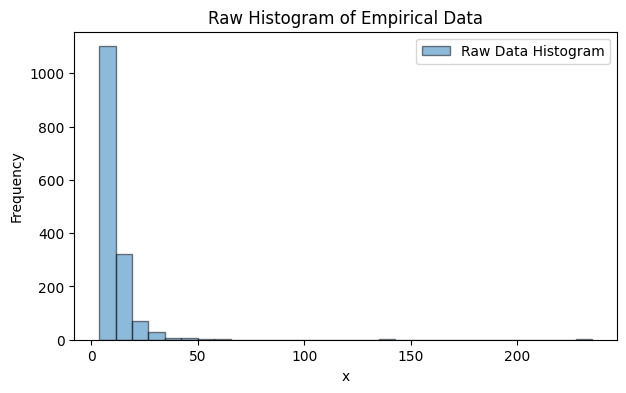

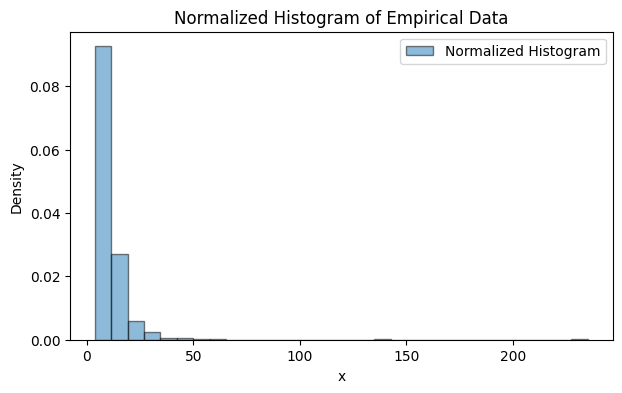

Data loaded. Number of points = 1540
Improved PDFs defined.
NLL functions + gradient fits for all 10 models (no multi-start).
Simulated Annealing defined.
Hybrid approach (SA + gradient) defined.

Optimizing Model #1...
  Gradient: Best Params=[0.48459403 9.64504756], NLL=4486.570939
  Annealing: Best Params=[0.48615433 9.71086627], NLL=4486.746305
  Hybrid:   Best Params=[0.4845941  9.64503338], NLL=4486.570939

Optimizing Model #2...


<ipython-input-1-28b4608bd961>:71: RuntimeWarning: overflow encountered in scalar divide
  denominator = (1.0 + (x ** c) / (b ** c)) ** (k + 1.0)
<ipython-input-1-28b4608bd961>:71: RuntimeWarning: overflow encountered in scalar power
  denominator = (1.0 + (x ** c) / (b ** c)) ** (k + 1.0)
<ipython-input-1-28b4608bd961>:70: RuntimeWarning: overflow encountered in scalar power
  numerator = (c * k / (b ** (c * k))) * (x ** (c * k - 1.0))


  Gradient: Best Params=[ 2.83471561 45.99265201  2.00019549], NLL=4300.903389
  Annealing: Best Params=[6.72616002e+00 6.24330435e-02 9.47786253e+01], NLL=6293.914111
  Hybrid:   Best Params=[ 2.83144908 45.54548673  2.00374998], NLL=4300.903946

Optimizing Model #3...
  Gradient: Best Params=[ 0.08439649 14.03049423], NLL=5185.214102
  Annealing: Best Params=[1.00000000e-06 1.40323603e+01], NLL=5185.214120
  Hybrid:   Best Params=[1.00000000e-06 1.40304769e+01], NLL=5185.214092

Optimizing Model #4...
  Gradient: Best Params=[2.79575776 7.67420337], NLL=4300.899190
  Annealing: Best Params=[2.79958557 7.67313685], NLL=4300.901592
  Hybrid:   Best Params=[2.79576346 7.67419835], NLL=4300.899190

Optimizing Model #5...
  Gradient: Best Params=[43.28519553 10.76150168], NLL=4467.937776
  Annealing: Best Params=[43.23279546 10.751574  ], NLL=4467.941014
  Hybrid:   Best Params=[43.2771125  10.76153948], NLL=4467.937792

Optimizing Model #6...
  Gradient: Best Params=[6.0925018], NLL=5865

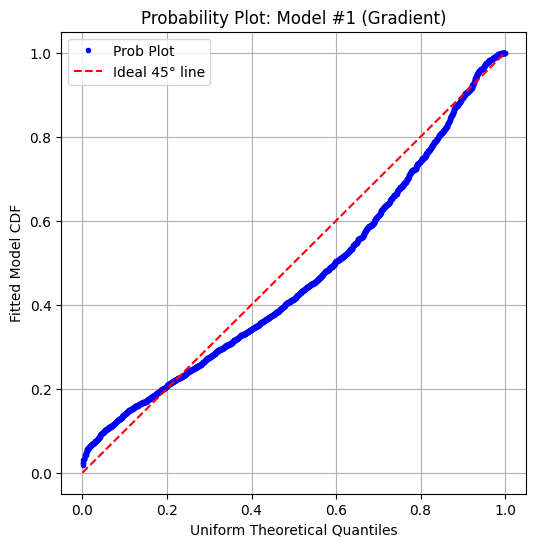

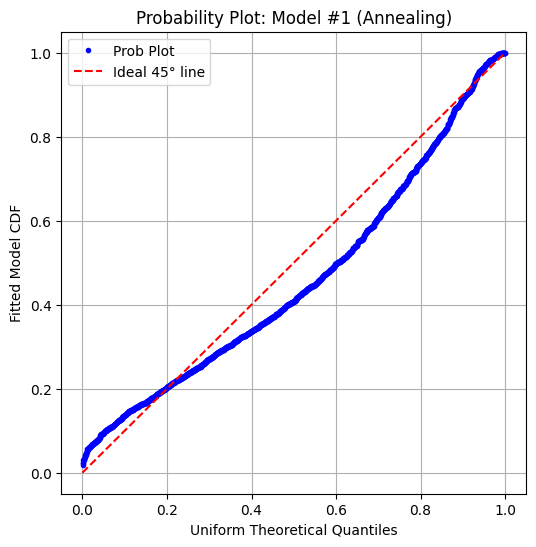

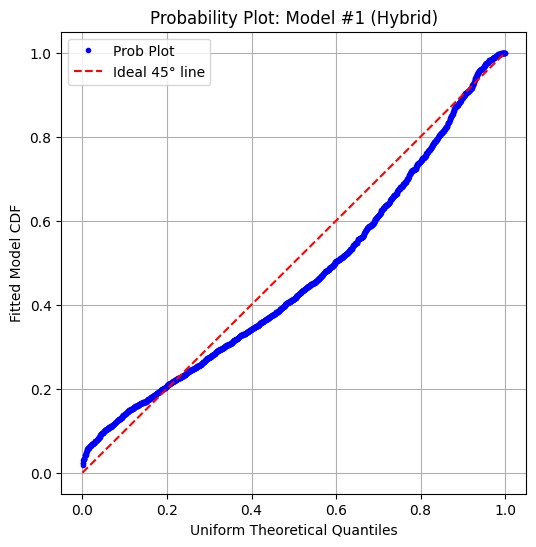

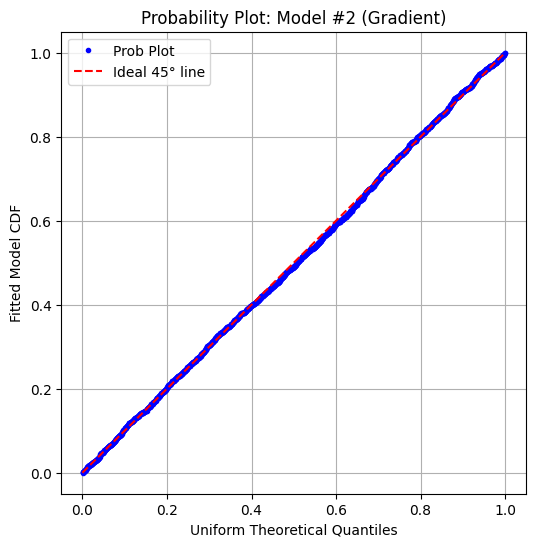

<ipython-input-1-28b4608bd961>:70: RuntimeWarning: divide by zero encountered in scalar power
  numerator = (c * k / (b ** (c * k))) * (x ** (c * k - 1.0))


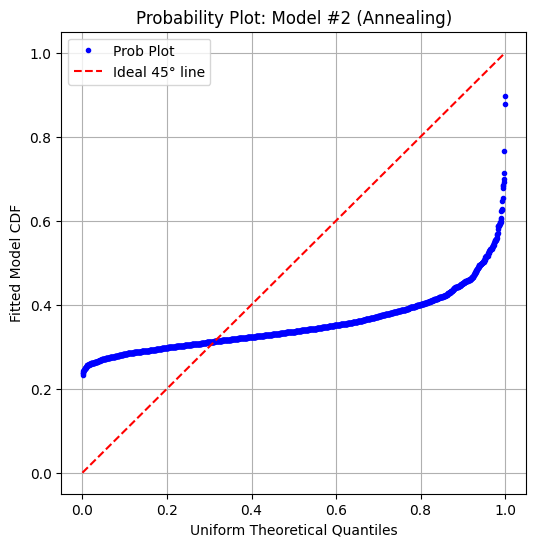

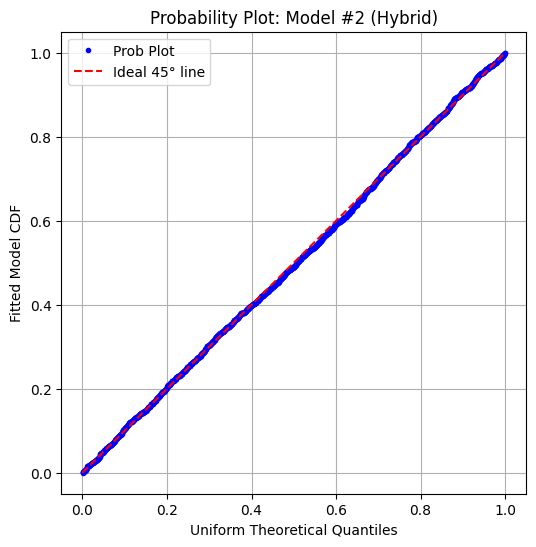

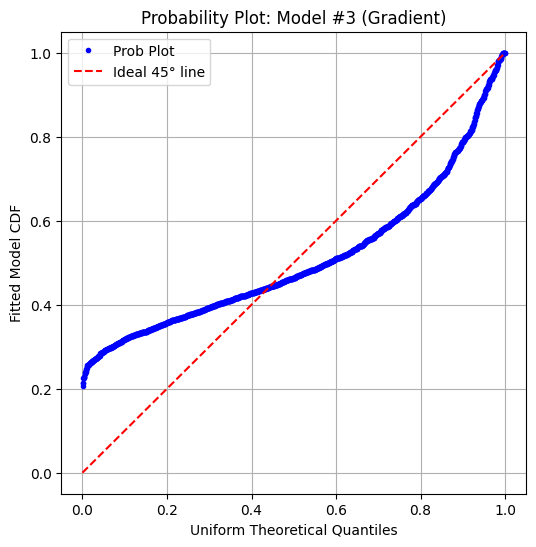

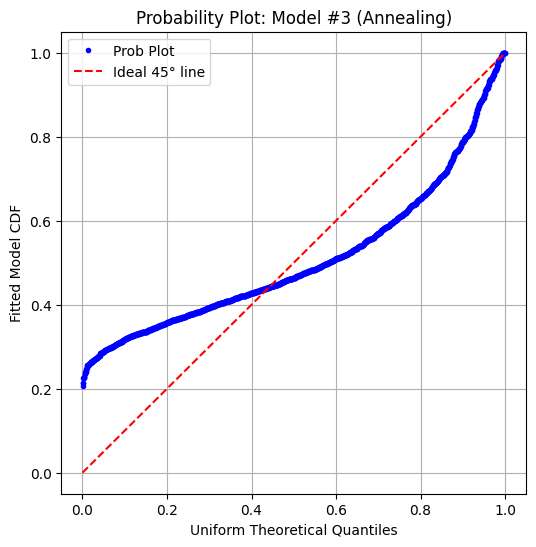

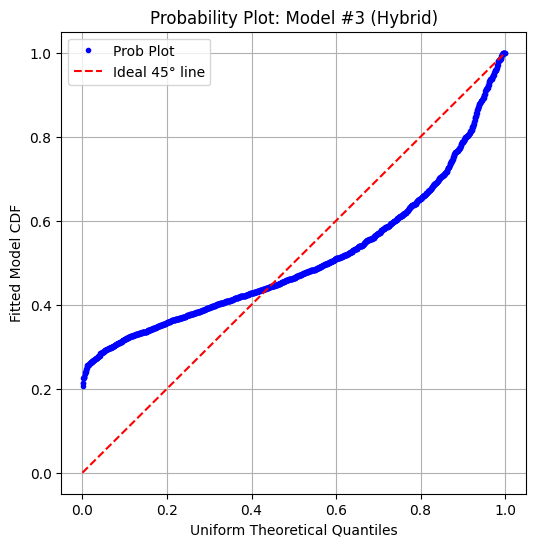

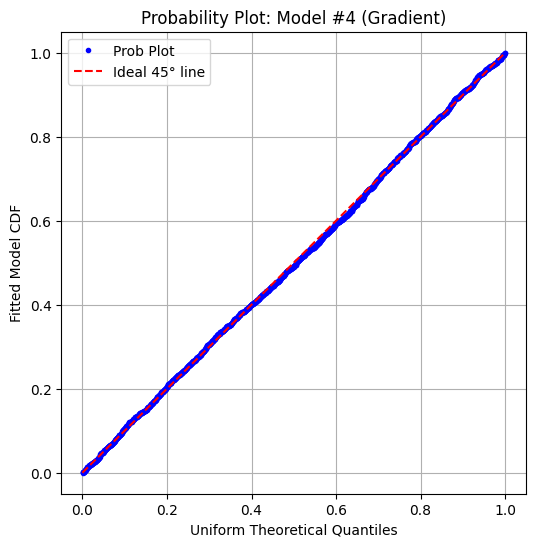

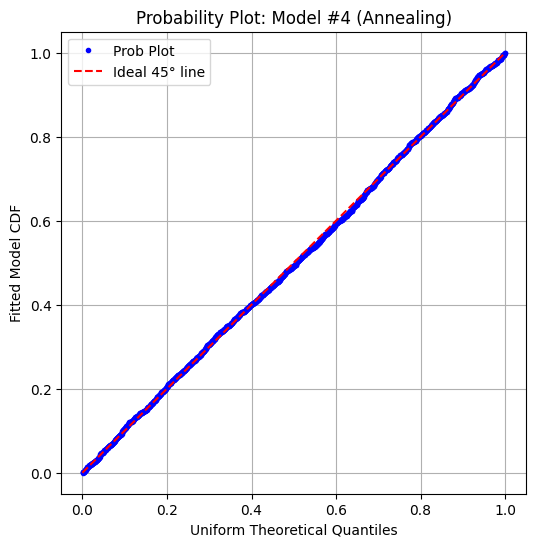

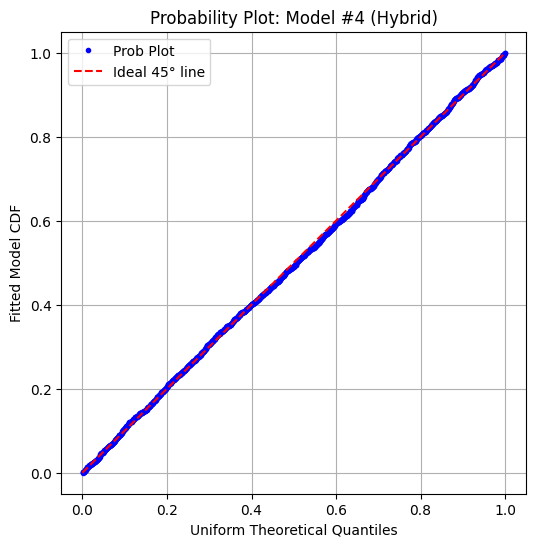

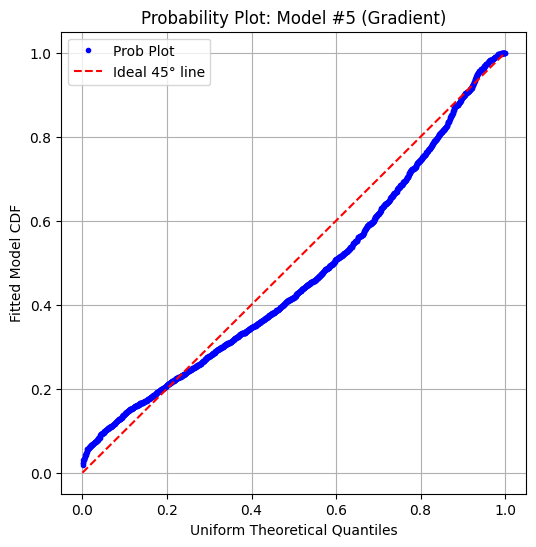

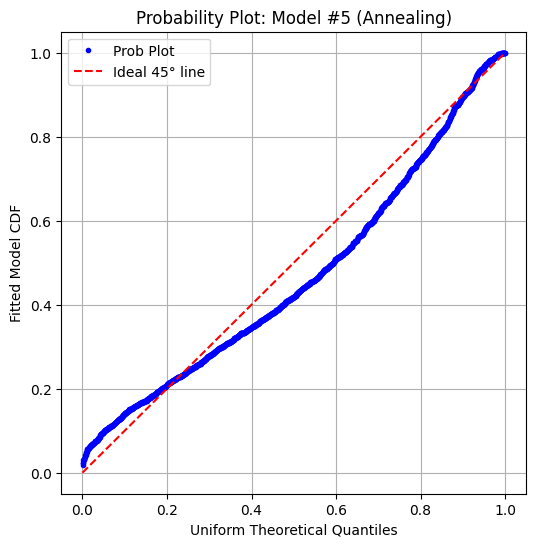

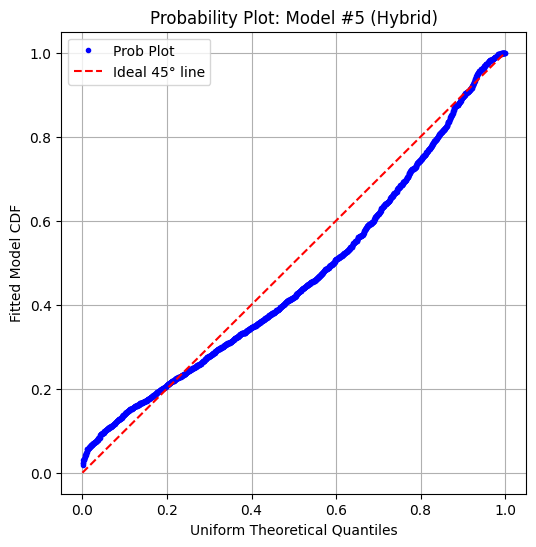

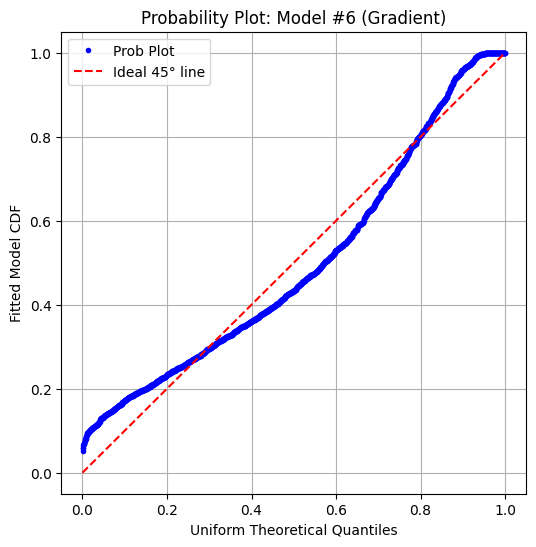

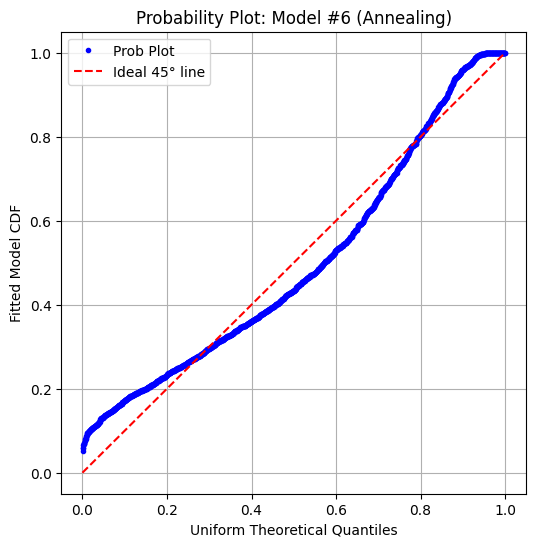

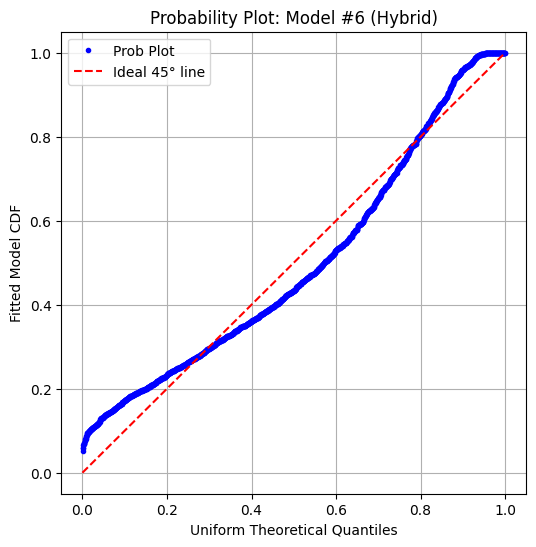

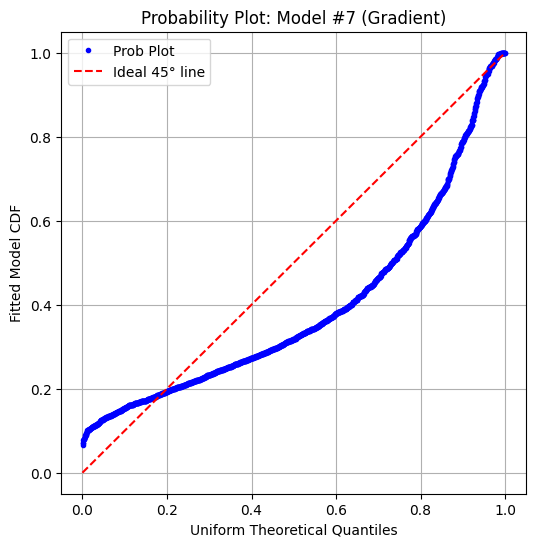

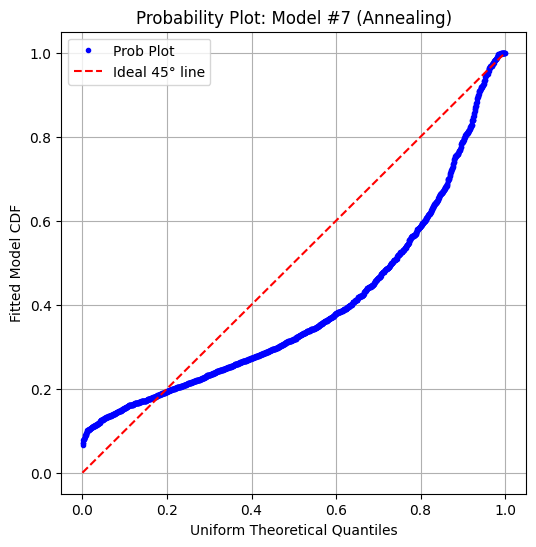

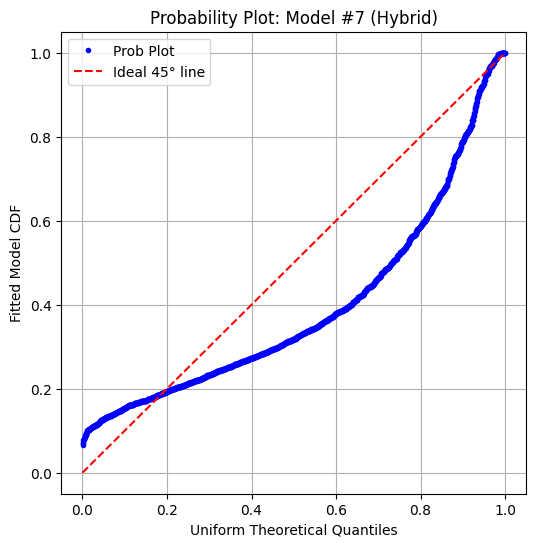

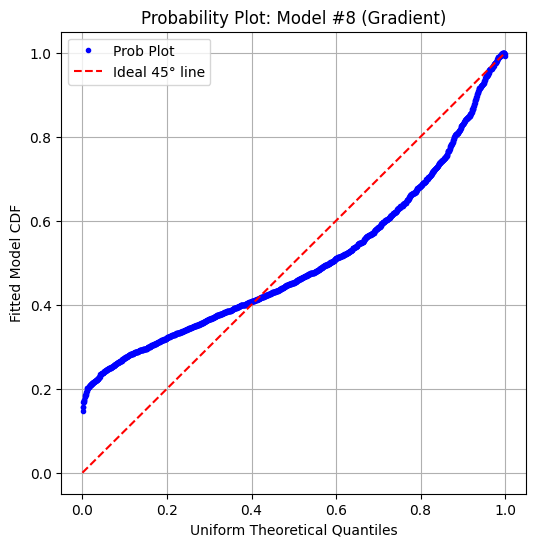

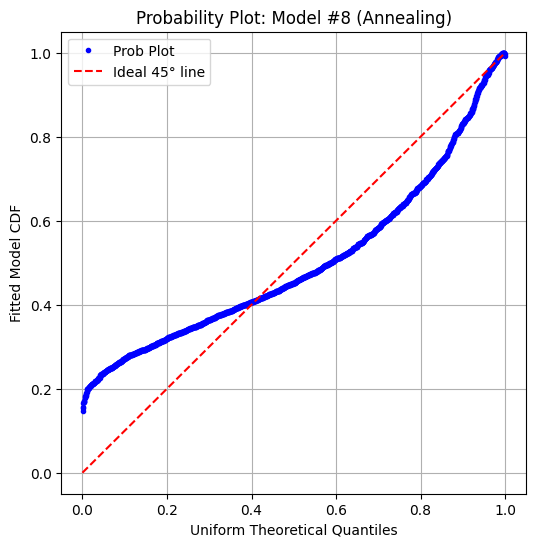

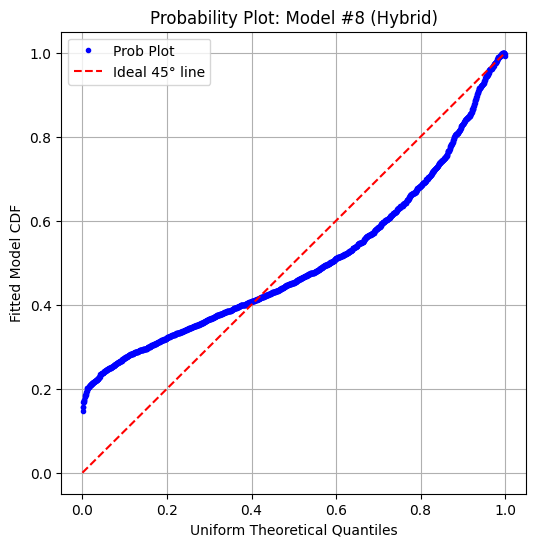

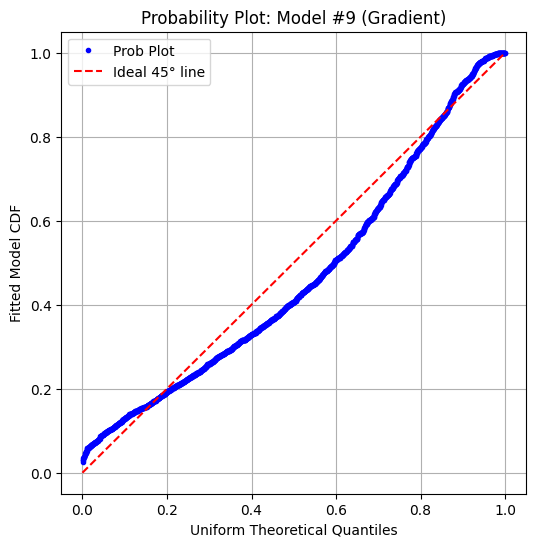

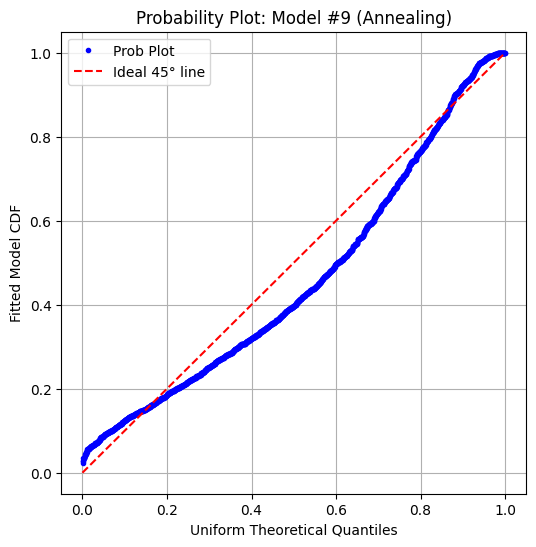

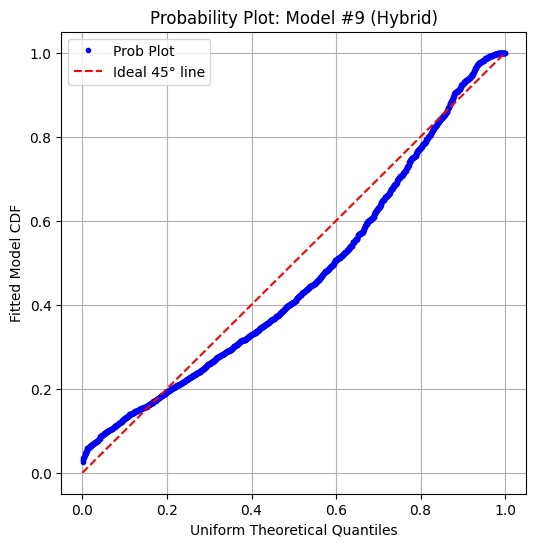

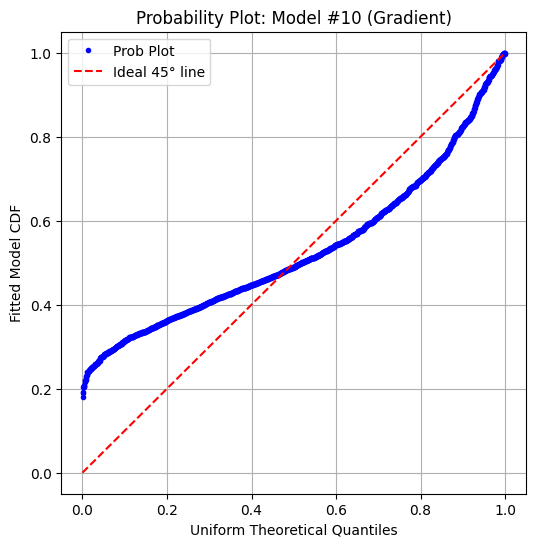

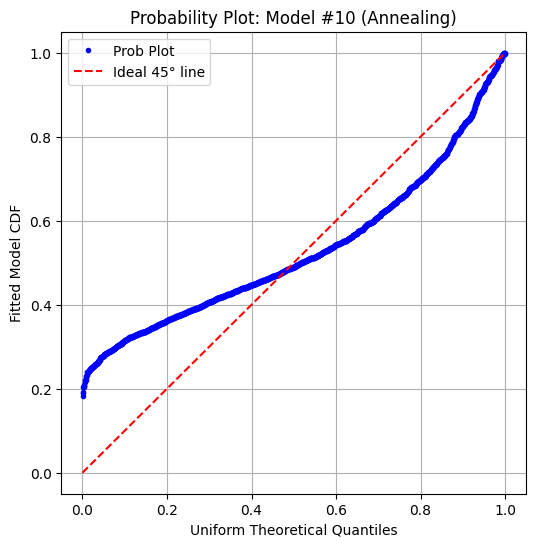

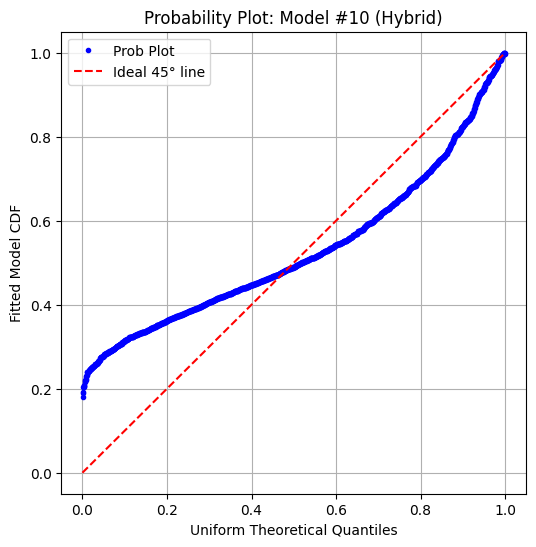

Plotted Probability Plots for all three methods, each for 10 models.

=== KS TEST RESULTS ===
Model #1 (gradient): KS stat=0.1048, p-value=0.0000, => REJECT at alpha=0.05
Model #1 (annealing): KS stat=0.1105, p-value=0.0000, => REJECT at alpha=0.05
Model #1 (hybrid): KS stat=0.1048, p-value=0.0000, => REJECT at alpha=0.05
Model #2 (gradient): KS stat=0.0146, p-value=1.0000, => FAIL TO REJECT at alpha=0.05
Model #2 (annealing): KS stat=0.4584, p-value=0.0000, => REJECT at alpha=0.05
Model #2 (hybrid): KS stat=0.0147, p-value=1.0000, => FAIL TO REJECT at alpha=0.05
Model #3 (gradient): KS stat=0.2435, p-value=0.0000, => REJECT at alpha=0.05
Model #3 (annealing): KS stat=0.2434, p-value=0.0000, => REJECT at alpha=0.05
Model #3 (hybrid): KS stat=0.2435, p-value=0.0000, => REJECT at alpha=0.05
Model #4 (gradient): KS stat=0.0141, p-value=1.0000, => FAIL TO REJECT at alpha=0.05
Model #4 (annealing): KS stat=0.0137, p-value=1.0000, => FAIL TO REJECT at alpha=0.05
Model #4 (hybrid): KS stat=0.

KeyboardInterrupt: 

In [ ]:
##############################################
# 0. IMPORTS & DATA LOADING
##############################################
import csv
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# For reproducibility in random sampling, etc.
random.seed(123)
np.random.seed(123)

##############################################
# 1. LOAD DATA + PLOT HISTOGRAMS
##############################################
data_file = "data26002204001.csv"  # your CSV file path
data = []
with open(data_file, "r") as f:
    reader = csv.reader(f)
    for row in reader:
        try:
            val = float(row[0])
            data.append(val)
        except ValueError:
            continue  # Skip rows that don't contain valid floats

data = np.array(data)
n = len(data)

# 1A. RAW HISTOGRAM
plt.figure(figsize=(7, 4))
plt.hist(data, bins=30, alpha=0.5, edgecolor='k', label="Raw Data Histogram")
plt.title("Raw Histogram of Empirical Data")
plt.xlabel("x")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 1B. NORMALIZED HISTOGRAM (counts / total => a PDF-like shape)
plt.figure(figsize=(7, 4))
plt.hist(data, bins=30, density=True, alpha=0.5, edgecolor='k', label="Normalized Histogram")
plt.title("Normalized Histogram of Empirical Data")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

print(f"Data loaded. Number of points = {n}")

##############################################
# 2. DEFINE THE 10 CANDIDATE PDFS (Improved)
##############################################
def pdf1(x, alpha, beta):
    if alpha <= 0 or beta <= 0 or x <= 0:
        return 1e-10
    try:
        denom = 2.0 * alpha * math.sqrt(2.0 * math.pi * beta) * (x ** 1.5)
        exponent = -((x - beta) ** 2) / (2.0 * (alpha ** 2) * beta * x)
        val = (math.exp(exponent) * (x + beta)) / denom
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf2(x, c, k, b):
    if x < 0 or c <= 0 or k <= 0 or b <= 0:
        return 1e-10
    try:
        numerator = (c * k / (b ** (c * k))) * (x ** (c * k - 1.0))
        denominator = (1.0 + (x ** c) / (b ** c)) ** (k + 1.0)
        if denominator <= 0 or math.isinf(numerator) or math.isinf(denominator):
            return 1e-10
        val = numerator / denominator
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf3(x, mu, sigma):
    if sigma <= 0 or x < 0:
        return 1e-10
    try:
        coeff = 1.0 / (sigma * math.sqrt(2.0 * math.pi))
        term1 = math.exp(-((x - mu) ** 2) / (2.0 * sigma ** 2))
        term2 = math.exp(-((x + mu) ** 2) / (2.0 * sigma ** 2))
        val = coeff * (term1 + term2)
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf4(x, c, sigma):
    if x <= 0 or c <= 0 or sigma <= 0:
        return 1e-10
    try:
        val = (c / x) * ((x / sigma) ** (-c)) * math.exp(-((x / sigma) ** (-c)))
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf5(x, lam, mu):
    if x <= 0 or lam <= 0 or mu <= 0:
        return 1e-10
    try:
        coeff = math.sqrt(lam / (2.0 * math.pi * (x ** 3)))
        exponent = - lam * ((x - mu) ** 2) / (2.0 * (mu ** 2) * x)
        val = coeff * math.exp(exponent)
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf6(x, sigma):
    if x < 0 or sigma <= 0:
        return 1e-10
    try:
        factor = math.sqrt(2.0 / math.pi) * (x ** 2) / (sigma ** 3)
        val = factor * math.exp(-(x ** 2) / (2.0 * sigma ** 2))
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf7(x, sigma):
    if x < 0 or sigma <= 0:
        return 1e-10
    try:
        val = (x / (sigma ** 2)) * math.exp(-(x ** 2) / (2.0 * sigma ** 2))
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf8(x, c, b):
    if x < 0 or c <= 0 or b <= 0:
        return 1e-10
    try:
        val = (c * (x ** (c - 1.0)) * math.exp(-((x ** c) / (b ** c)))) / (b ** c)
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf9(x, lam, mu):
    if x < 0 or lam <= 0 or mu <= 0:
        return 1e-10
    try:
        expr1 = math.exp(-x * lam)
        expr2 = expr1 * mu
        val = math.exp(-x * lam - expr2)
        bracket = lam * (1.0 + (1.0 - expr1) * mu)
        result = val * bracket
        return result if result > 0 and not math.isnan(result) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf10(x, sigma):
    if x < 0 or sigma <= 0:
        return 1e-10
    try:
        const = ((sigma ** 2) * (1.0 + x)) / (1.0 + sigma)
        exponent = -x * sigma
        val = const * math.exp(exponent)
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

print("Improved PDFs defined.")

##############################################
# 3. NLL AND BASIC FIT (Gradient-based) FOR ALL MODELS
##############################################
def nll_1(params, data_array):
    alpha, beta = params
    if alpha <= 0 or beta <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf1(x, alpha, beta)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf1_gradient(data_array):
    init = [0.5, 33.0]
    bnds = [(1e-6, None), (1e-6, None)]  # No explicit upper bound
    res = minimize(lambda p: nll_1(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_2(params, data_array):
    c_, k_, b_ = params
    if c_ <= 0 or k_ <= 0 or b_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf2(x, c_, k_, b_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf2_gradient(data_array):
    init = [1.0, 1.5, 100.0]
    bnds = [(1e-6, None), (1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_2(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_3(params, data_array):
    mu_, sigma_ = params
    if sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf3(x, mu_, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf3_gradient(data_array):
    init = [3.0, 9.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_3(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_4(params, data_array):
    c_, sigma_ = params
    if c_ <= 0 or sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf4(x, c_, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf4_gradient(data_array):
    init = [4.0, 9.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_4(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_5(params, data_array):
    lam_, mu_ = params
    if lam_ <= 0 or mu_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf5(x, lam_, mu_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf5_gradient(data_array):
    init = [3.0, 10.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_5(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_6(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf6(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf6_gradient(data_array):
    init = [4.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_6(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_7(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf7(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf7_gradient(data_array):
    init = [3.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_7(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_8(params, data_array):
    c_, b_ = params
    if c_ <= 0 or b_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf8(x, c_, b_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf8_gradient(data_array):
    init = [1.0, 1.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_8(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_9(params, data_array):
    lam_, mu_ = params
    if lam_ <= 0 or mu_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf9(x, lam_, mu_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf9_gradient(data_array):
    init = [6.0, 3.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_9(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_10(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf10(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf10_gradient(data_array):
    init = [3.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_10(p, data_array), init, bounds=bnds, options={'maxiter':1000})
    return res.x, res.fun

print("NLL functions + gradient fits for all 10 models (no multi-start).")

##############################################
# 4. SIMULATED ANNEALING (SA)
##############################################
def simulated_annealing(nll_func, init_params, data_array,
                        max_iter=2000, temp_start=10.0, temp_end=0.1, alpha=0.99):
    """
    Simple Simulated Annealing (SA) approach.
    """
    import copy

    current_params = np.array(init_params, dtype=np.float64)
    current_nll = nll_func(current_params, data_array)
    best_params = copy.deepcopy(current_params)
    best_nll = current_nll

    temp = temp_start

    for i in range(max_iter):
        candidate = current_params + np.random.normal(0, 1, size=len(current_params))
        # Clip positivity
        candidate = np.clip(candidate, 1e-6, 1e9)

        cand_nll = nll_func(candidate, data_array)

        if cand_nll < current_nll:
            current_params = candidate
            current_nll = cand_nll
            if cand_nll < best_nll:
                best_params = candidate
                best_nll = cand_nll
        else:
            diff = cand_nll - current_nll
            prob = math.exp(-diff / temp) if temp > 0 else 0
            if np.random.rand() < prob:
                current_params = candidate
                current_nll = cand_nll

        temp = max(temp_end, temp * alpha)

    return best_params, best_nll

print("Simulated Annealing defined.")

##############################################
# 5. HYBRID (SA + Gradient)
##############################################
def fit_hybrid(nll_func, init_params, data_array):
    """
    Hybrid approach: SA followed by Gradient-based optimization.
    """
    # 1) Simulated Annealing
    sa_params, sa_nll = simulated_annealing(nll_func, init_params, data_array,
                                           max_iter=1000,
                                           temp_start=10.0, temp_end=0.01, alpha=0.98)
    # 2) Gradient-based Refinement
    param_bounds = [(1e-6, None)] * len(sa_params)
    res = minimize(lambda p: nll_func(p, data_array), sa_params, bounds=param_bounds)
    return res.x, res.fun

print("Hybrid approach (SA + gradient) defined.")

##############################################
# 6. ORGANIZE MODELS AND FITTING FUNCTIONS
##############################################
def model_nll_and_inits():
    """
    Return a dictionary:
      model_name -> (nll_function, gradient_fit_function, init_for_SA)
    We'll rely on single init param for gradient + same init for SA/hybrid.
    """
    return {
        "Model #1":  (nll_1,  fit_pdf1_gradient,  [0.5, 33.0]),
        "Model #2":  (nll_2,  fit_pdf2_gradient,  [1.0, 1.5, 100.0]),
        "Model #3":  (nll_3,  fit_pdf3_gradient,  [3.0, 9.0]),
        "Model #4":  (nll_4,  fit_pdf4_gradient,  [4.0, 9.0]),
        "Model #5":  (nll_5,  fit_pdf5_gradient,  [3.0, 10.0]),
        "Model #6":  (nll_6,  fit_pdf6_gradient,  [4.0]),
        "Model #7":  (nll_7,  fit_pdf7_gradient,  [3.0]),
        "Model #8":  (nll_8,  fit_pdf8_gradient,  [1.0, 1.0]),
        "Model #9":  (nll_9,  fit_pdf9_gradient,  [6.0, 3.0]),
        "Model #10": (nll_10, fit_pdf10_gradient, [3.0]),
    }

# Define model_fits as a list of tuples: (model_name, fit_function, number_of_parameters)
model_fits = [
    ("Model #1", fit_pdf1_gradient, 2),
    ("Model #2", fit_pdf2_gradient, 3),
    ("Model #3", fit_pdf3_gradient, 2),
    ("Model #4", fit_pdf4_gradient, 2),
    ("Model #5", fit_pdf5_gradient, 2),
    ("Model #6", fit_pdf6_gradient, 1),
    ("Model #7", fit_pdf7_gradient, 1),
    ("Model #8", fit_pdf8_gradient, 2),
    ("Model #9", fit_pdf9_gradient, 2),
    ("Model #10", fit_pdf10_gradient, 1),
]

# Initialize results dictionary and all_results list
results = {}
all_results = []
method_names = ["gradient", "annealing", "hybrid"]

# Retrieve model mapping
model_dict = model_nll_and_inits()

for (mname, fit_func, k) in model_fits:
    print(f"\nOptimizing {mname}...")
    nll_func, gradient_fit_func, init_for_SA = model_dict[mname]

    # 1) Gradient
    best_g, best_nll_g = gradient_fit_func(data)
    print(f"  Gradient: Best Params={best_g}, NLL={best_nll_g:.6f}")

    # 2) Simulated Annealing
    best_sa, best_nll_sa = simulated_annealing(nll_func, init_for_SA, data)
    print(f"  Annealing: Best Params={best_sa}, NLL={best_nll_sa:.6f}")

    # 3) Hybrid
    best_hyb, best_nll_hyb = fit_hybrid(nll_func, init_for_SA, data)
    print(f"  Hybrid:   Best Params={best_hyb}, NLL={best_nll_hyb:.6f}")

    # Store results
    results[mname] = {
        "gradient":   (best_g,   best_nll_g),
        "annealing":  (best_sa,  best_nll_sa),
        "hybrid":     (best_hyb, best_nll_hyb)
    }

    # Append to all_results for plotting and further analysis
    all_results.append(("gradient", mname, best_g, best_nll_g, k))
    all_results.append(("annealing", mname, best_sa, best_nll_sa, k))
    all_results.append(("hybrid", mname, best_hyb, best_nll_hyb, k))

print("\nAll models optimized with Gradient, Annealing, and Hybrid methods (single init).")

##############################################
# 7. PROBABILITY PLOTS
##############################################
def numeric_cdf(pdf_func, x, params, n_steps=200):
    if x <= 0:
        return 0.0
    try:
        xs = np.linspace(0, x, n_steps)
        vals = [pdf_func(xx, *params) for xx in xs]
    except TypeError as e:
        print(f"Error in numeric_cdf for x={x} with params={params}: {e}")
        return 0.0
    except Exception as e:
        print(f"Unexpected error in numeric_cdf for x={x} with params={params}: {e}")
        return 0.0

    # Replace negative or NaN values with 0 to prevent invalid areas
    vals = [v if v > 0 and not math.isnan(v) else 0.0 for v in vals]

    area = 0.0
    for i in range(n_steps - 1):
        area += 0.5 * (vals[i] + vals[i+1]) * (xs[i+1] - xs[i])
    return area

def probability_plot(method, data_array, pdf_func, params, model_name="Model"):
    sorted_data = np.sort(data_array)
    n_ = len(sorted_data)

    # Model-based CDF for each x_j
    model_cdf_vals = []
    for x_val in sorted_data:
        cdf_val = numeric_cdf(pdf_func, x_val, params)
        model_cdf_vals.append(cdf_val)

    # Compare to uniform quantiles
    uniform_q = [(i + 0.5) / n_ for i in range(n_)]

    plt.figure(figsize=(6,6))
    plt.plot(uniform_q, model_cdf_vals, 'bo', markersize=3, label='Prob Plot')
    plt.plot([0,1], [0,1], 'r--', label='Ideal 45° line')
    plt.title(f"Probability Plot: {model_name} ({method.capitalize()})")
    plt.xlabel("Uniform Theoretical Quantiles")
    plt.ylabel("Fitted Model CDF")
    plt.legend()
    plt.grid(True)
    plt.show()

# Iterate over all_results to create plots for each method
for entry in all_results:
    method, mname, params, nll_val, k = entry

    # Select the correct PDF function
    if mname == "Model #1":
        pdf_ = pdf1
    elif mname == "Model #2":
        pdf_ = pdf2
    elif mname == "Model #3":
        pdf_ = pdf3
    elif mname == "Model #4":
        pdf_ = pdf4
    elif mname == "Model #5":
        pdf_ = pdf5
    elif mname == "Model #6":
        pdf_ = pdf6
    elif mname == "Model #7":
        pdf_ = pdf7
    elif mname == "Model #8":
        pdf_ = pdf8
    elif mname == "Model #9":
        pdf_ = pdf9
    elif mname == "Model #10":
        pdf_ = pdf10
    else:
        pdf_ = None

    # Plot probability plot
    if pdf_ is not None and params is not None:
        probability_plot(method, data, pdf_, params, model_name=mname)

print("Plotted Probability Plots for all three methods, each for 10 models.")

##############################################
# 8. KS TEST + P-VALUES
##############################################
def ks_test(data_array, pdf_func, params, n_steps=200):
    # numeric cdf
    def cdf_func(x):
        return numeric_cdf(pdf_func, x, params, n_steps=n_steps)
    sorted_data = np.sort(data_array)
    n_ = len(sorted_data)
    max_diff = 0.0
    for i, x_val in enumerate(sorted_data):
        F_emp = (i + 1) / n_
        F_model = cdf_func(x_val)
        diff = abs(F_emp - F_model)
        if diff > max_diff:
            max_diff = diff
    return max_diff

def ks_pvalue(ks_stat, sample_size):
    p_approx = 2 * math.exp(-2 * (ks_stat ** 2) * sample_size)
    return min(max(p_approx, 0.0), 1.0)

alpha = 0.05  # significance level
print("\n=== KS TEST RESULTS ===")
for entry in all_results:
    method, mname, params, nll_val, k = entry

    # Select the correct PDF function
    if mname == "Model #1":
        pdf_ = pdf1
    elif mname == "Model #2":
        pdf_ = pdf2
    elif mname == "Model #3":
        pdf_ = pdf3
    elif mname == "Model #4":
        pdf_ = pdf4
    elif mname == "Model #5":
        pdf_ = pdf5
    elif mname == "Model #6":
        pdf_ = pdf6
    elif mname == "Model #7":
        pdf_ = pdf7
    elif mname == "Model #8":
        pdf_ = pdf8
    elif mname == "Model #9":
        pdf_ = pdf9
    elif mname == "Model #10":
        pdf_ = pdf10
    else:
        pdf_ = None

    if pdf_ is None or params is None:
        ks_stat = np.nan
        p_val = np.nan
    else:
        ks_stat = ks_test(data, pdf_, params)
        p_val = ks_pvalue(ks_stat, n)

    decision = "FAIL TO REJECT" if p_val > alpha else "REJECT"
    print(f"{mname} ({method}): KS stat={ks_stat:.4f}, p-value={p_val:.4f}, => {decision} at alpha={alpha}")

##############################################
# 9. AIC/BIC
##############################################
def compute_aic_bic(logL, num_params, sample_size):
    # AIC = 2*k - 2*logL
    # BIC = k*ln(n) - 2*logL
    k = num_params
    n_ = sample_size
    AIC_ = 2 * k - 2 * logL
    BIC_ = k * math.log(n_) - 2 * logL
    return AIC_, BIC_

print("\n=== AIC/BIC RESULTS ===")
for entry in all_results:
    method, mname, params, nll_val, k = entry
    logL = -nll_val
    AIC_, BIC_ = compute_aic_bic(logL, k, n)
    print(f"{mname} ({method}): AIC={AIC_:.4f}, BIC={BIC_:.4f}, logL={logL:.4f}")

##############################################
# 10. 95% CONFIDENCE INTERVALS (BOOTSTRAP)
##############################################
def bootstrap_fit(nll_func, pdf_func, params_init, data_array, method, k, B=1000, alpha=0.05):
    """
    Perform bootstrap to estimate confidence intervals for model parameters.

    Parameters:
    - nll_func: Function to compute Negative Log-Likelihood
    - pdf_func: PDF function corresponding to the model
    - params_init: Initial parameter estimates (from the best fit)
    - data_array: Original data array
    - method: Optimization method used ('gradient', 'annealing', 'hybrid')
    - k: Number of parameters
    - B: Number of bootstrap samples
    - alpha: Significance level for confidence intervals

    Returns:
    - ci_lower: Lower bounds of confidence intervals
    - ci_upper: Upper bounds of confidence intervals
    """
    bootstrap_params = []
    for i in range(B):
        # Sample with replacement
        sample_indices = np.random.randint(0, n, n)
        sample = data_array[sample_indices]

        # Fit the model to the bootstrap sample using the same method
        if method == "gradient":
            # Reuse the gradient-based fitting function
            fit_func = {
                "Model #1": fit_pdf1_gradient,
                "Model #2": fit_pdf2_gradient,
                "Model #3": fit_pdf3_gradient,
                "Model #4": fit_pdf4_gradient,
                "Model #5": fit_pdf5_gradient,
                "Model #6": fit_pdf6_gradient,
                "Model #7": fit_pdf7_gradient,
                "Model #8": fit_pdf8_gradient,
                "Model #9": fit_pdf9_gradient,
                "Model #10": fit_pdf10_gradient,
            }.get(mname, None)
            if fit_func is None:
                continue  # Skip if no fitting function found
            fitted_params, _ = fit_func(sample)

        elif method == "annealing":
            # Reuse the SA function
            sa_params, _ = simulated_annealing(nll_func, params_init, sample)
            fitted_params = sa_params

        elif method == "hybrid":
            # Reuse the hybrid function
            hyb_params, _ = fit_hybrid(nll_func, params_init, sample)
            fitted_params = hyb_params

        else:
            continue  # Unsupported method

        # Check if fitting was successful
        if np.any(np.isinf(fitted_params)) or np.any(np.isnan(fitted_params)):
            continue  # Skip invalid fits

        bootstrap_params.append(fitted_params)

    bootstrap_params = np.array(bootstrap_params)
    if bootstrap_params.size == 0:
        print("No valid bootstrap samples were obtained.")
        return None, None

    # Calculate confidence intervals
    ci_lower = np.percentile(bootstrap_params, 100 * (alpha/2), axis=0)
    ci_upper = np.percentile(bootstrap_params, 100 * (1 - alpha/2), axis=0)

    return ci_lower, ci_upper

# Identify the best model based on AIC
# We'll find the model-method combination with the lowest AIC
best_aic = np.inf
best_entry = None

for entry in all_results:
    method, mname, params, nll_val, k = entry
    logL = -nll_val
    AIC_, BIC_ = compute_aic_bic(logL, k, n)
    if AIC_ < best_aic:
        best_aic = AIC_
        best_entry = entry

if best_entry is not None:
    method, mname, params, nll_val, k = best_entry
    print(f"\nBest Model Based on AIC: {mname} ({method}) with AIC={best_aic:.4f}")

    # Retrieve the corresponding nll_func and pdf_func
    if mname == "Model #1":
        pdf_func = pdf1
        nll_func = nll_1
    elif mname == "Model #2":
        pdf_func = pdf2
        nll_func = nll_2
    elif mname == "Model #3":
        pdf_func = pdf3
        nll_func = nll_3
    elif mname == "Model #4":
        pdf_func = pdf4
        nll_func = nll_4
    elif mname == "Model #5":
        pdf_func = pdf5
        nll_func = nll_5
    elif mname == "Model #6":
        pdf_func = pdf6
        nll_func = nll_6
    elif mname == "Model #7":
        pdf_func = pdf7
        nll_func = nll_7
    elif mname == "Model #8":
        pdf_func = pdf8
        nll_func = nll_8
    elif mname == "Model #9":
        pdf_func = pdf9
        nll_func = nll_9
    elif mname == "Model #10":
        pdf_func = pdf10
        nll_func = nll_10
    else:
        pdf_func = None
        nll_func = None

    if pdf_func is not None and nll_func is not None:
        # Perform bootstrap
        ci_lower, ci_upper = bootstrap_fit(nll_func, pdf_func, params_init=params,
                                          data_array=data, method=method, k=k, B=1000, alpha=0.05)

        if ci_lower is not None and ci_upper is not None:
            # Display confidence intervals
            print(f"\n95% Confidence Intervals for {mname} ({method}):")
            for idx, (lower, upper) in enumerate(zip(ci_lower, ci_upper)):
                print(f"  Parameter {idx+1}: {lower:.4f} <= theta <= {upper:.4f}")

            # Optional: Plot parameter distributions
            # To visualize, we need to collect all bootstrap samples
            # Modify the bootstrap_fit function to return bootstrap_params
            # Let's adjust the function slightly to return them if needed
            # For now, we'll skip plotting to save computational resources
        else:
            print("Failed to compute confidence intervals due to insufficient valid bootstrap samples.")
    else:
        print("PDF function or NLL function not found for the best model.")
else:
    print("No valid best model found based on AIC.")

##############################################
# WRAP-UP
##############################################
print("\nAll steps completed.")
print("We have 30 parameter sets (10 models × 3 methods).")
print("We have Probability Plots, KS test, and AIC/BIC for all solutions.")
print("95% Confidence Intervals have been computed for the best model based on AIC.")


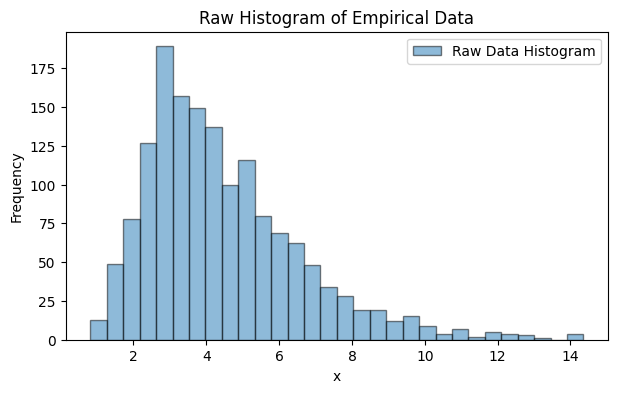

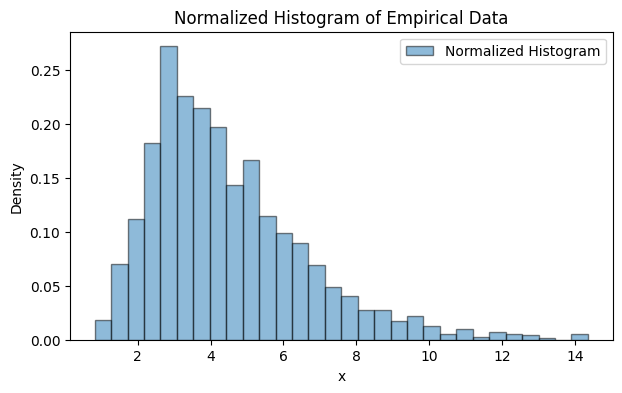

Data loaded. Number of points = 1540
Improved PDFs defined.
NLL functions + gradient fits for all 10 models (no multi-start).
Simulated Annealing defined.
Hybrid approach (SA + gradient) defined.

Optimizing Model #1...
  Gradient: Best Params=[0.48202832 3.99907983], NLL=3157.041088
  Annealing: Best Params=[0.46631941 4.02535478], NLL=3158.930894
  Hybrid:   Best Params=[0.48202841 3.99907855], NLL=3157.041088

Optimizing Model #2...


<ipython-input-2-fc6182d7ff4b>:71: RuntimeWarning: divide by zero encountered in scalar divide
  denominator = (1.0 + (x ** c) / (b ** c)) ** (k + 1.0)
<ipython-input-2-fc6182d7ff4b>:71: RuntimeWarning: overflow encountered in scalar power
  denominator = (1.0 + (x ** c) / (b ** c)) ** (k + 1.0)
<ipython-input-2-fc6182d7ff4b>:71: RuntimeWarning: invalid value encountered in scalar divide
  denominator = (1.0 + (x ** c) / (b ** c)) ** (k + 1.0)


  Gradient: Best Params=[3.65430117 1.0497807  3.9344175 ], NLL=3174.250239
  Annealing: Best Params=[ 2.25649083  0.15535013 92.91472117], NLL=5451.125975


<ipython-input-2-fc6182d7ff4b>:70: RuntimeWarning: divide by zero encountered in scalar divide
  numerator = (c * k / (b ** (c * k))) * (x ** (c * k - 1.0))
<ipython-input-2-fc6182d7ff4b>:70: RuntimeWarning: overflow encountered in scalar power
  numerator = (c * k / (b ** (c * k))) * (x ** (c * k - 1.0))
<ipython-input-2-fc6182d7ff4b>:70: RuntimeWarning: invalid value encountered in scalar multiply
  numerator = (c * k / (b ** (c * k))) * (x ** (c * k - 1.0))


  Hybrid:   Best Params=[3.65431638 1.04976581 3.93444188], NLL=3174.250239

Optimizing Model #3...
  Gradient: Best Params=[4.4397302  2.19713991], NLL=3352.763450
  Annealing: Best Params=[4.45120777 2.16664626], NLL=3353.026427
  Hybrid:   Best Params=[4.43971228 2.19714906], NLL=3352.763450

Optimizing Model #4...
  Gradient: Best Params=[2.09843425 3.16266655], NLL=3299.055123
  Annealing: Best Params=[2.09300504 3.17569818], NLL=3299.106733
  Hybrid:   Best Params=[2.0984325  3.16266563], NLL=3299.055123

Optimizing Model #5...
  Gradient: Best Params=[18.15820661  4.46416204], NLL=3158.358398
  Annealing: Best Params=[18.08576866  4.46539799], NLL=3158.364781
  Hybrid:   Best Params=[18.15819215  4.46416703], NLL=3158.358398

Optimizing Model #6...
  Gradient: Best Params=[2.85998362], NLL=3238.464265
  Annealing: Best Params=[2.86058683], NLL=3238.464470
  Hybrid:   Best Params=[2.85998284], NLL=3238.464265

Optimizing Model #7...
  Gradient: Best Params=[3.50275046], NLL=3263.

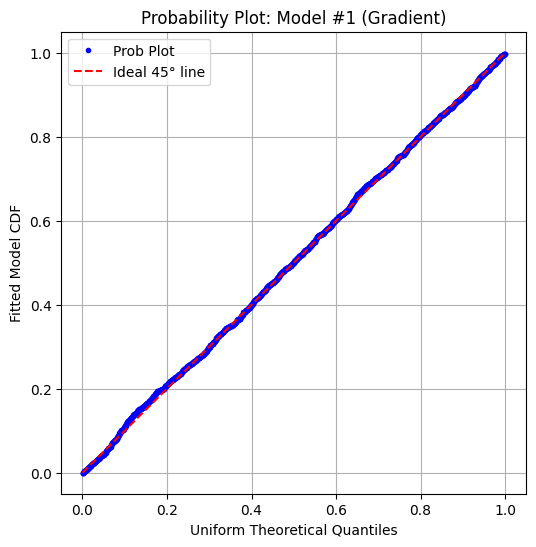

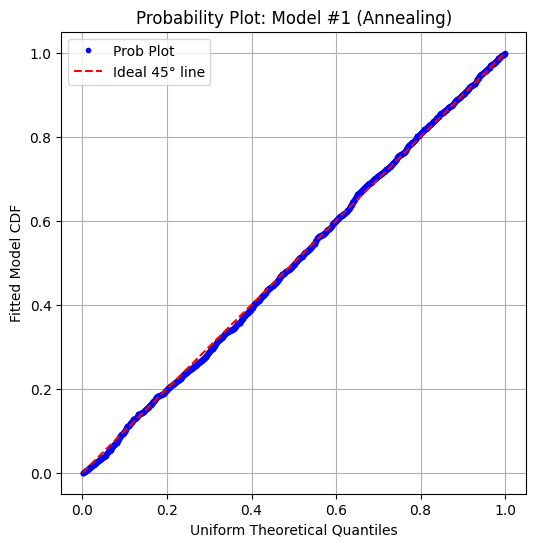

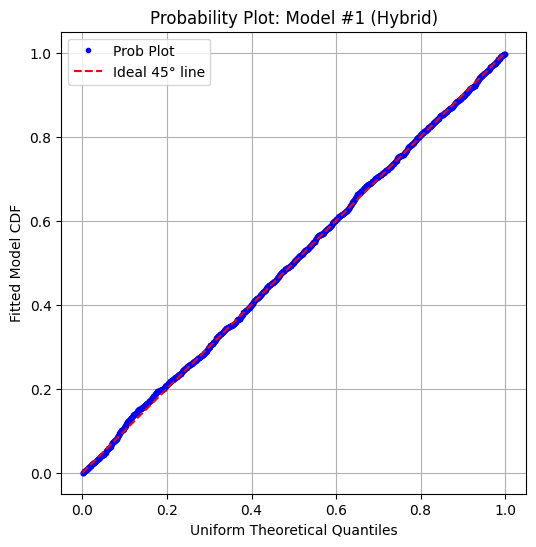

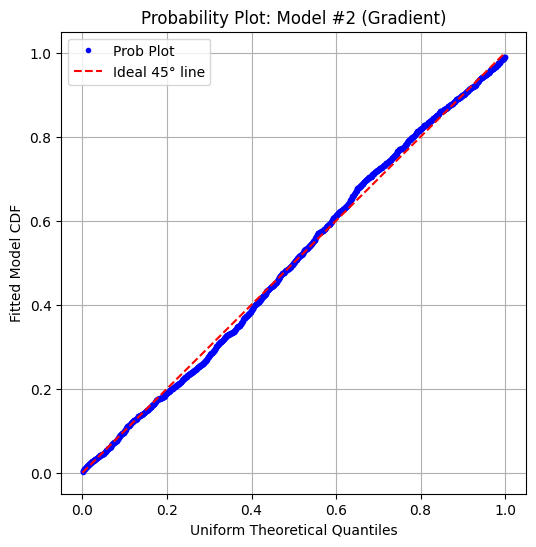

<ipython-input-2-fc6182d7ff4b>:70: RuntimeWarning: divide by zero encountered in scalar power
  numerator = (c * k / (b ** (c * k))) * (x ** (c * k - 1.0))


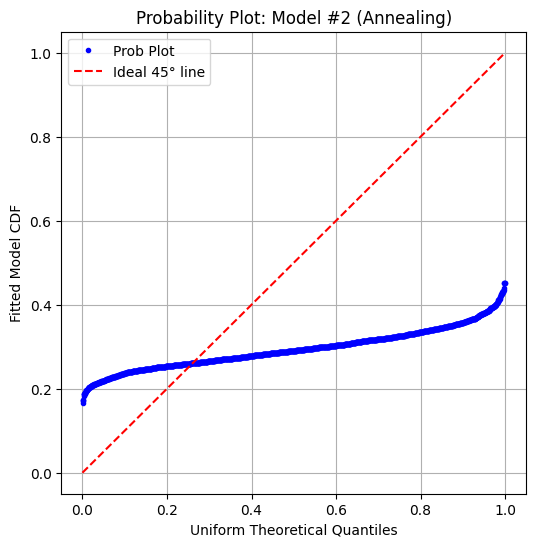

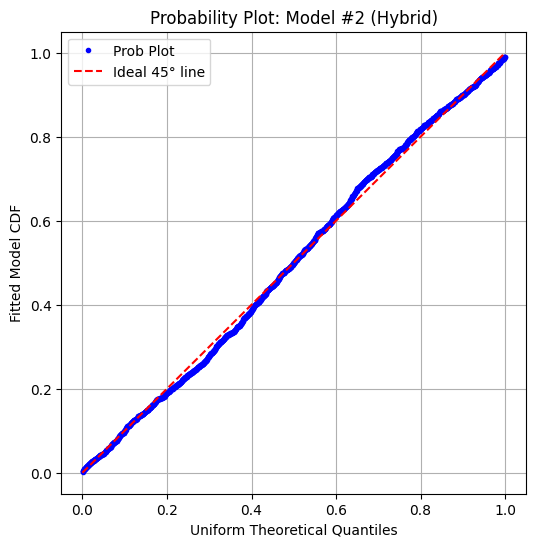

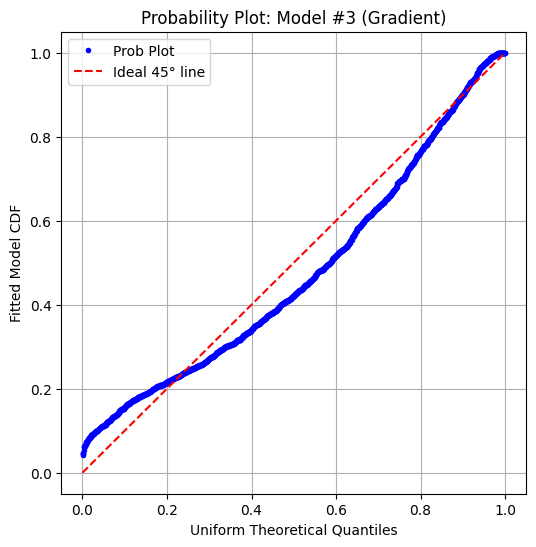

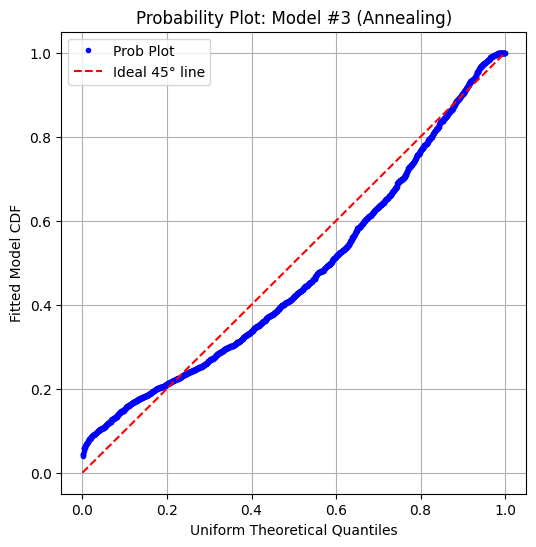

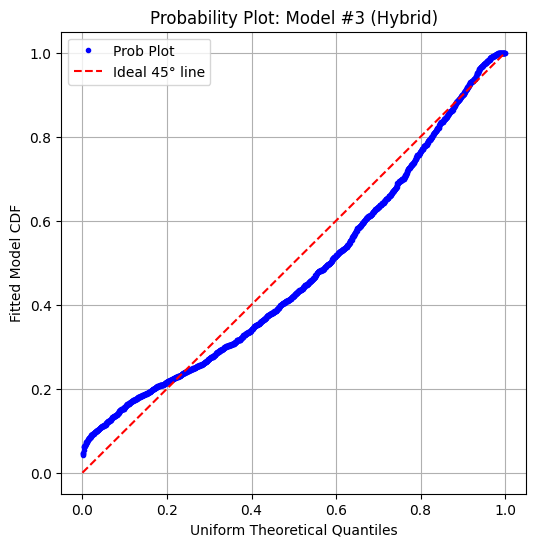

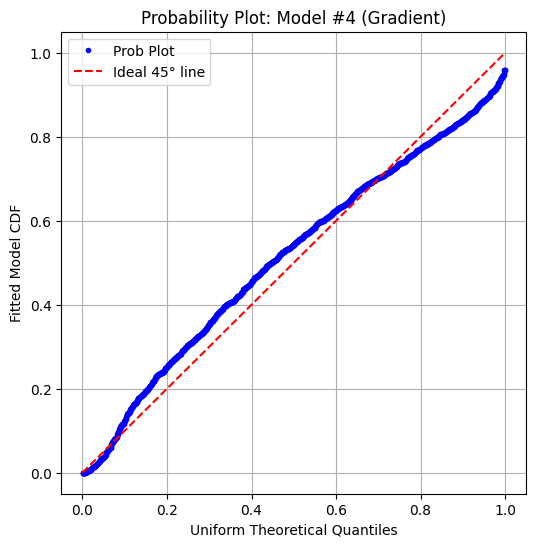

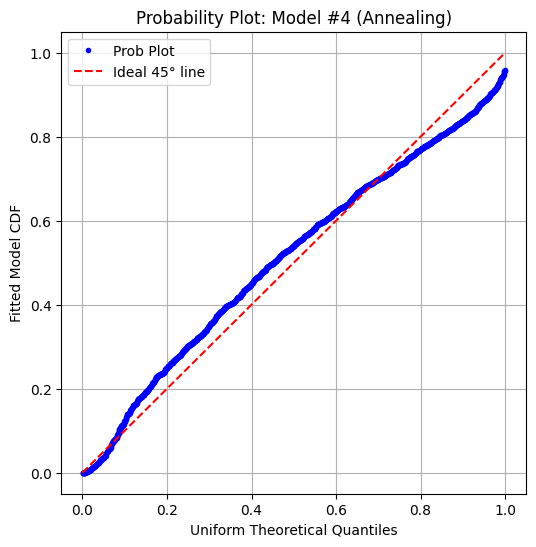

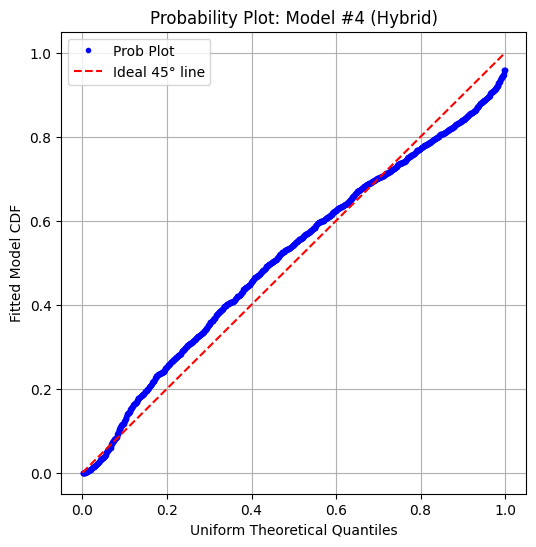

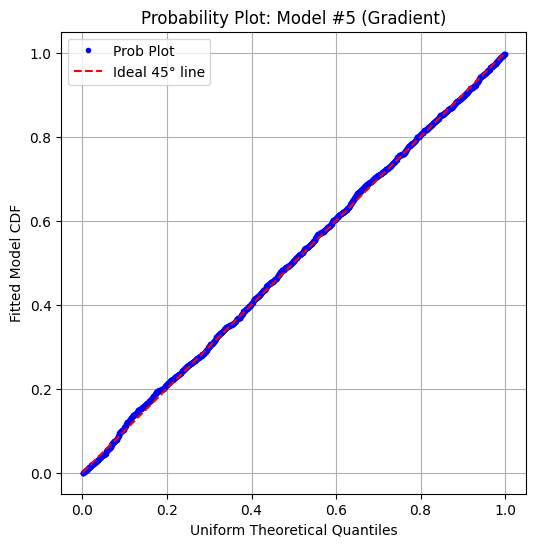

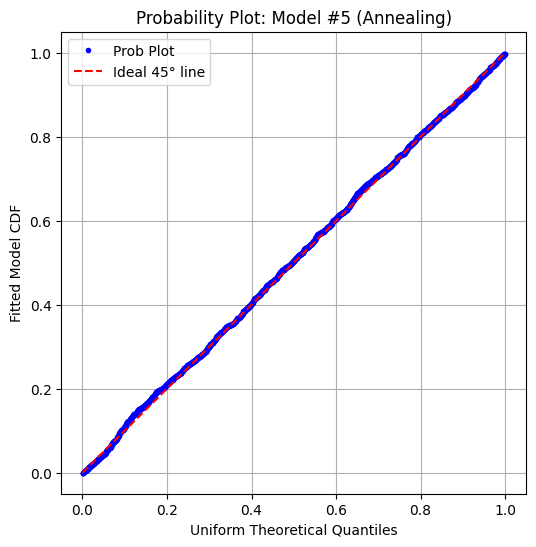

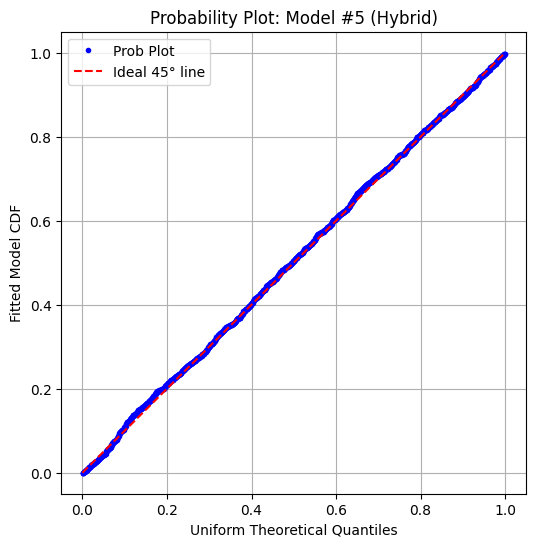

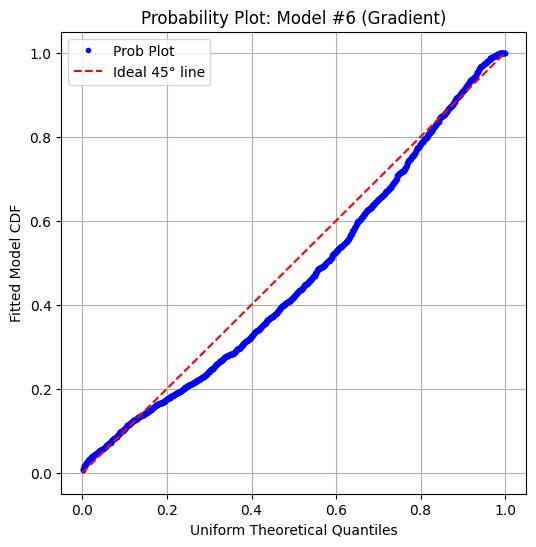

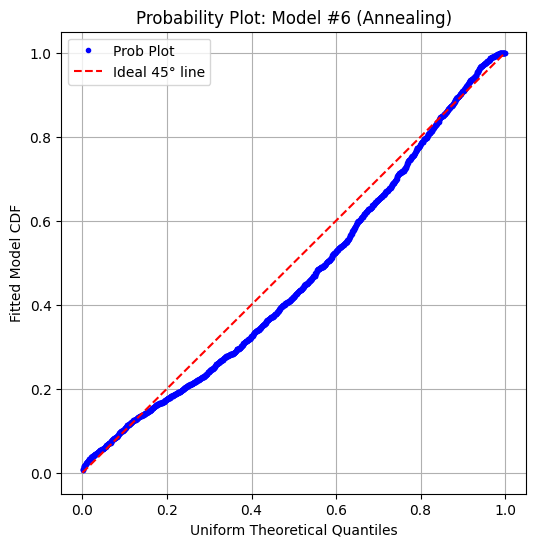

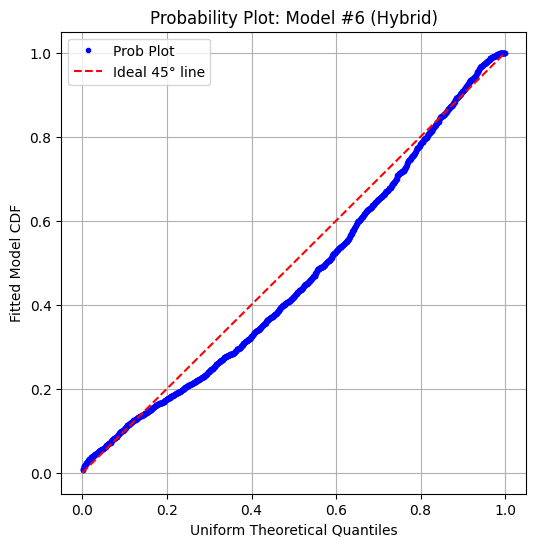

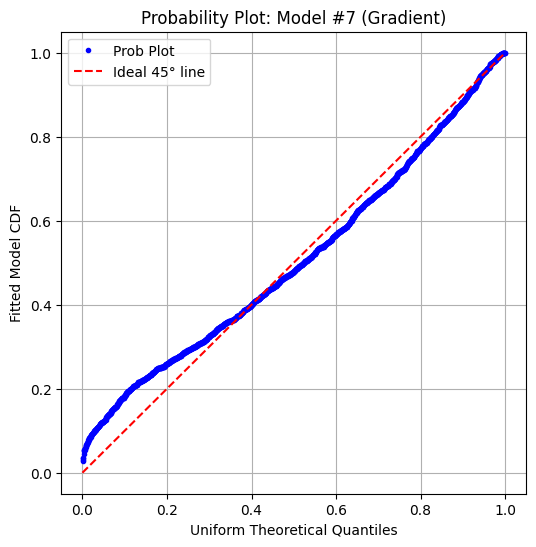

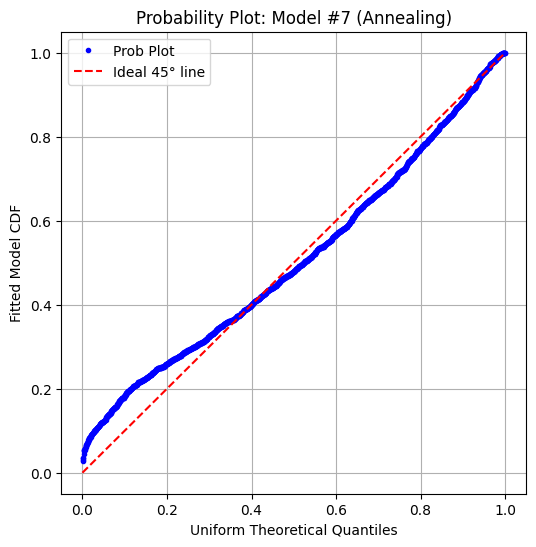

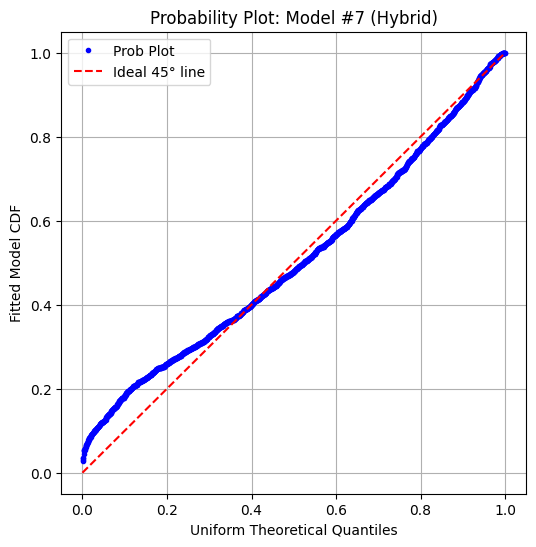

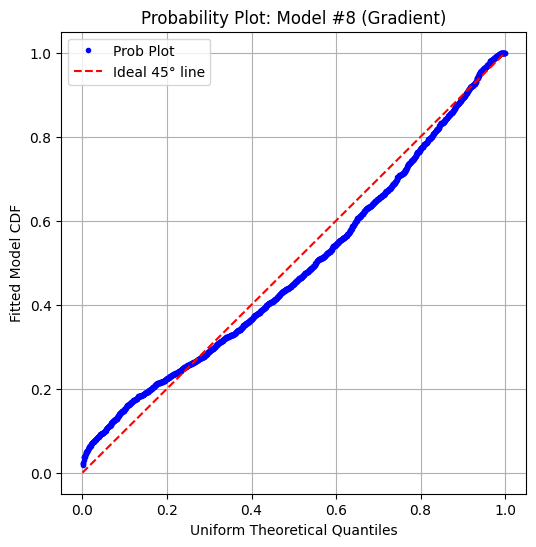

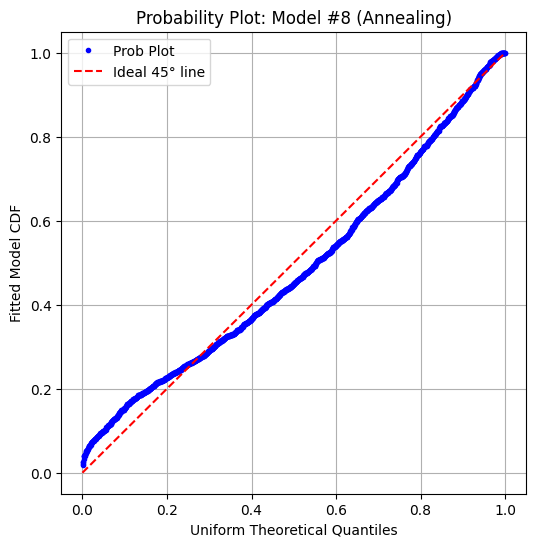

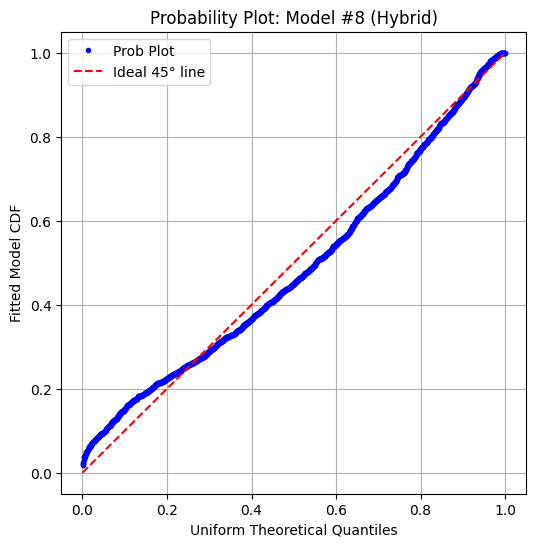

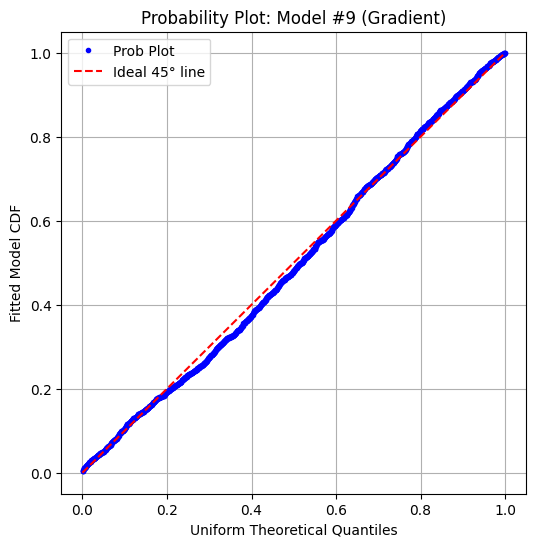

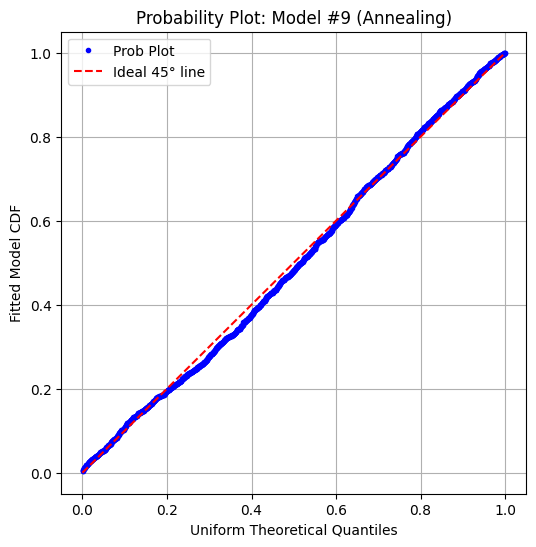

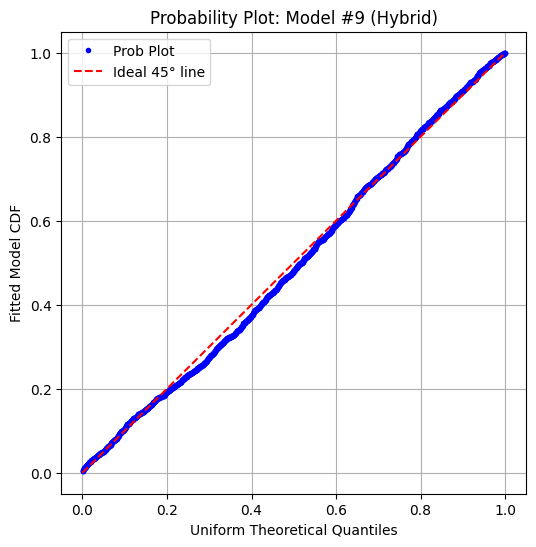

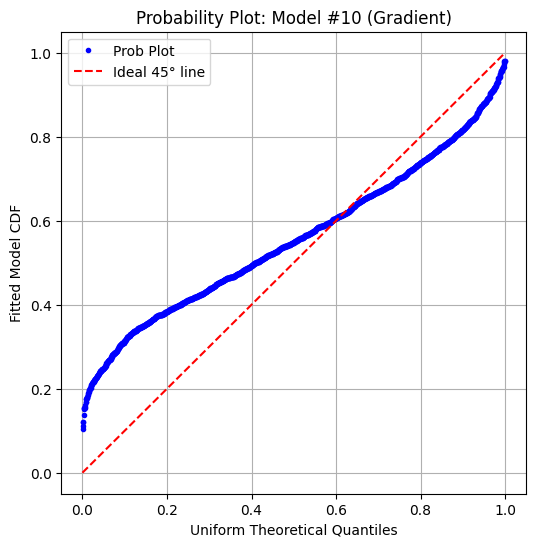

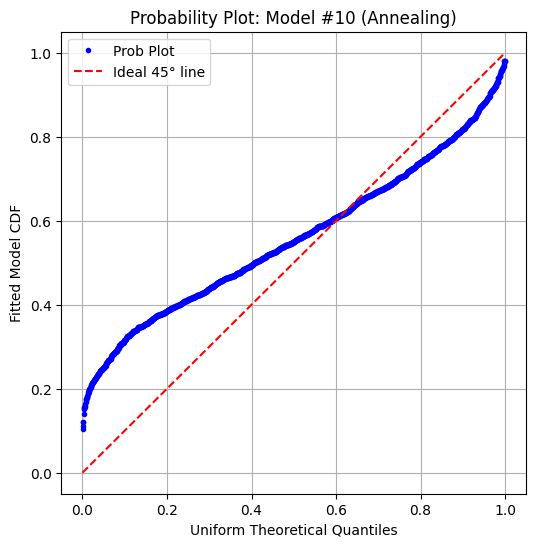

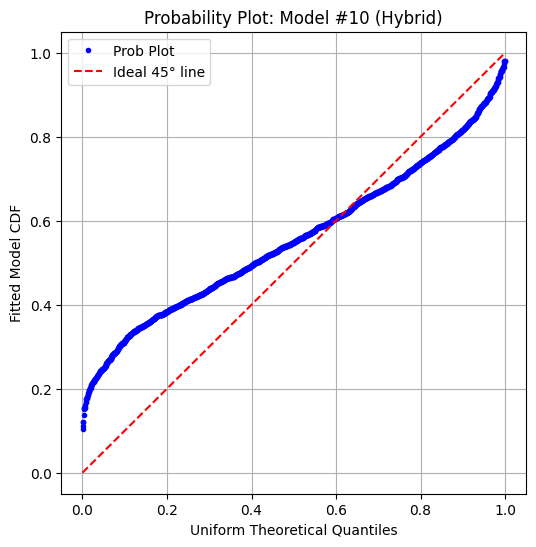

Plotted Probability Plots for all three methods, each for 10 models.

=== KS TEST RESULTS ===
Model #1 (gradient): KS stat=0.0182, p-value=0.7229, => FAIL TO REJECT at alpha=0.05
Model #1 (annealing): KS stat=0.0165, p-value=0.8629, => FAIL TO REJECT at alpha=0.05
Model #1 (hybrid): KS stat=0.0182, p-value=0.7229, => FAIL TO REJECT at alpha=0.05
Model #2 (gradient): KS stat=0.0274, p-value=0.1964, => FAIL TO REJECT at alpha=0.05
Model #2 (annealing): KS stat=0.5789, p-value=0.0000, => REJECT at alpha=0.05
Model #2 (hybrid): KS stat=0.0274, p-value=0.1965, => FAIL TO REJECT at alpha=0.05
Model #3 (gradient): KS stat=0.0879, p-value=0.0000, => REJECT at alpha=0.05
Model #3 (annealing): KS stat=0.0896, p-value=0.0000, => REJECT at alpha=0.05
Model #3 (hybrid): KS stat=0.0879, p-value=0.0000, => REJECT at alpha=0.05
Model #4 (gradient): KS stat=0.0682, p-value=0.0000, => REJECT at alpha=0.05
Model #4 (annealing): KS stat=0.0699, p-value=0.0000, => REJECT at alpha=0.05
Model #4 (hybrid): KS

KeyboardInterrupt: 

In [ ]:
##############################################
# 0. IMPORTS & DATA LOADING
##############################################
import csv
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# For reproducibility in random sampling, etc.
random.seed(123)
np.random.seed(123)

##############################################
# 1. LOAD DATA + PLOT HISTOGRAMS
##############################################
data_file = "data26002204540.csv"  # your CSV file path
data = []
with open(data_file, "r") as f:
    reader = csv.reader(f)
    for row in reader:
        try:
            val = float(row[0])
            data.append(val)
        except ValueError:
            continue  # Skip rows that don't contain valid floats

data = np.array(data)
n = len(data)

# 1A. RAW HISTOGRAM
plt.figure(figsize=(7, 4))
plt.hist(data, bins=30, alpha=0.5, edgecolor='k', label="Raw Data Histogram")
plt.title("Raw Histogram of Empirical Data")
plt.xlabel("x")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 1B. NORMALIZED HISTOGRAM (counts / total => a PDF-like shape)
plt.figure(figsize=(7, 4))
plt.hist(data, bins=30, density=True, alpha=0.5, edgecolor='k', label="Normalized Histogram")
plt.title("Normalized Histogram of Empirical Data")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

print(f"Data loaded. Number of points = {n}")

##############################################
# 2. DEFINE THE 10 CANDIDATE PDFS (Improved)
##############################################
def pdf1(x, alpha, beta):
    if alpha <= 0 or beta <= 0 or x <= 0:
        return 1e-10
    try:
        denom = 2.0 * alpha * math.sqrt(2.0 * math.pi * beta) * (x ** 1.5)
        exponent = -((x - beta) ** 2) / (2.0 * (alpha ** 2) * beta * x)
        val = (math.exp(exponent) * (x + beta)) / denom
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf2(x, c, k, b):
    if x < 0 or c <= 0 or k <= 0 or b <= 0:
        return 1e-10
    try:
        numerator = (c * k / (b ** (c * k))) * (x ** (c * k - 1.0))
        denominator = (1.0 + (x ** c) / (b ** c)) ** (k + 1.0)
        if denominator <= 0 or math.isinf(numerator) or math.isinf(denominator):
            return 1e-10
        val = numerator / denominator
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf3(x, mu, sigma):
    if sigma <= 0 or x < 0:
        return 1e-10
    try:
        coeff = 1.0 / (sigma * math.sqrt(2.0 * math.pi))
        term1 = math.exp(-((x - mu) ** 2) / (2.0 * sigma ** 2))
        term2 = math.exp(-((x + mu) ** 2) / (2.0 * sigma ** 2))
        val = coeff * (term1 + term2)
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf4(x, c, sigma):
    if x <= 0 or c <= 0 or sigma <= 0:
        return 1e-10
    try:
        val = (c / x) * ((x / sigma) ** (-c)) * math.exp(-((x / sigma) ** (-c)))
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf5(x, lam, mu):
    if x <= 0 or lam <= 0 or mu <= 0:
        return 1e-10
    try:
        coeff = math.sqrt(lam / (2.0 * math.pi * (x ** 3)))
        exponent = - lam * ((x - mu) ** 2) / (2.0 * (mu ** 2) * x)
        val = coeff * math.exp(exponent)
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf6(x, sigma):
    if x < 0 or sigma <= 0:
        return 1e-10
    try:
        factor = math.sqrt(2.0 / math.pi) * (x ** 2) / (sigma ** 3)
        val = factor * math.exp(-(x ** 2) / (2.0 * sigma ** 2))
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf7(x, sigma):
    if x < 0 or sigma <= 0:
        return 1e-10
    try:
        val = (x / (sigma ** 2)) * math.exp(-(x ** 2) / (2.0 * sigma ** 2))
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf8(x, c, b):
    if x < 0 or c <= 0 or b <= 0:
        return 1e-10
    try:
        val = (c * (x ** (c - 1.0)) * math.exp(-((x ** c) / (b ** c)))) / (b ** c)
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf9(x, lam, mu):
    if x < 0 or lam <= 0 or mu <= 0:
        return 1e-10
    try:
        expr1 = math.exp(-x * lam)
        expr2 = expr1 * mu
        val = math.exp(-x * lam - expr2)
        bracket = lam * (1.0 + (1.0 - expr1) * mu)
        result = val * bracket
        return result if result > 0 and not math.isnan(result) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf10(x, sigma):
    if x < 0 or sigma <= 0:
        return 1e-10
    try:
        const = ((sigma ** 2) * (1.0 + x)) / (1.0 + sigma)
        exponent = -x * sigma
        val = const * math.exp(exponent)
        return val if val > 0 and not math.isnan(val) else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

print("Improved PDFs defined.")

##############################################
# 3. NLL AND BASIC FIT (Gradient-based) FOR ALL MODELS
##############################################
def nll_1(params, data_array):
    alpha, beta = params
    if alpha <= 0 or beta <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf1(x, alpha, beta)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf1_gradient(data_array):
    init = [0.5, 33.0]
    bnds = [(1e-6, None), (1e-6, None)]  # No explicit upper bound
    res = minimize(lambda p: nll_1(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_2(params, data_array):
    c_, k_, b_ = params
    if c_ <= 0 or k_ <= 0 or b_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf2(x, c_, k_, b_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf2_gradient(data_array):
    init = [1.0, 1.5, 100.0]
    bnds = [(1e-6, None), (1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_2(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_3(params, data_array):
    mu_, sigma_ = params
    if sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf3(x, mu_, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf3_gradient(data_array):
    init = [3.0, 9.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_3(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_4(params, data_array):
    c_, sigma_ = params
    if c_ <= 0 or sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf4(x, c_, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf4_gradient(data_array):
    init = [4.0, 9.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_4(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_5(params, data_array):
    lam_, mu_ = params
    if lam_ <= 0 or mu_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf5(x, lam_, mu_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf5_gradient(data_array):
    init = [3.0, 10.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_5(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_6(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf6(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf6_gradient(data_array):
    init = [4.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_6(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_7(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf7(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf7_gradient(data_array):
    init = [3.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_7(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_8(params, data_array):
    c_, b_ = params
    if c_ <= 0 or b_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf8(x, c_, b_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf8_gradient(data_array):
    init = [1.0, 1.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_8(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_9(params, data_array):
    lam_, mu_ = params
    if lam_ <= 0 or mu_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf9(x, lam_, mu_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf9_gradient(data_array):
    init = [6.0, 3.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_9(p, data_array), init, bounds=bnds)
    return res.x, res.fun


def nll_10(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf
    total = 0.0
    for x in data_array:
        val = pdf10(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf10_gradient(data_array):
    init = [3.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_10(p, data_array), init, bounds=bnds, options={'maxiter':1000})
    return res.x, res.fun

print("NLL functions + gradient fits for all 10 models (no multi-start).")

##############################################
# 4. SIMULATED ANNEALING (SA)
##############################################
def simulated_annealing(nll_func, init_params, data_array,
                        max_iter=2000, temp_start=10.0, temp_end=0.1, alpha=0.99):
    """
    Simple Simulated Annealing (SA) approach.
    """
    import copy

    current_params = np.array(init_params, dtype=np.float64)
    current_nll = nll_func(current_params, data_array)
    best_params = copy.deepcopy(current_params)
    best_nll = current_nll

    temp = temp_start

    for i in range(max_iter):
        candidate = current_params + np.random.normal(0, 1, size=len(current_params))
        # Clip positivity
        candidate = np.clip(candidate, 1e-6, 1e9)

        cand_nll = nll_func(candidate, data_array)

        if cand_nll < current_nll:
            current_params = candidate
            current_nll = cand_nll
            if cand_nll < best_nll:
                best_params = candidate
                best_nll = cand_nll
        else:
            diff = cand_nll - current_nll
            prob = math.exp(-diff / temp) if temp > 0 else 0
            if np.random.rand() < prob:
                current_params = candidate
                current_nll = cand_nll

        temp = max(temp_end, temp * alpha)

    return best_params, best_nll

print("Simulated Annealing defined.")

##############################################
# 5. HYBRID (SA + Gradient)
##############################################
def fit_hybrid(nll_func, init_params, data_array):
    """
    Hybrid approach: SA followed by Gradient-based optimization.
    """
    # 1) Simulated Annealing
    sa_params, sa_nll = simulated_annealing(nll_func, init_params, data_array,
                                           max_iter=1000,
                                           temp_start=10.0, temp_end=0.01, alpha=0.98)
    # 2) Gradient-based Refinement
    param_bounds = [(1e-6, None)] * len(sa_params)
    res = minimize(lambda p: nll_func(p, data_array), sa_params, bounds=param_bounds)
    return res.x, res.fun

print("Hybrid approach (SA + gradient) defined.")

##############################################
# 6. ORGANIZE MODELS AND FITTING FUNCTIONS
##############################################
def model_nll_and_inits():
    """
    Return a dictionary:
      model_name -> (nll_function, gradient_fit_function, init_for_SA)
    We'll rely on single init param for gradient + same init for SA/hybrid.
    """
    return {
        "Model #1":  (nll_1,  fit_pdf1_gradient,  [0.5, 33.0]),
        "Model #2":  (nll_2,  fit_pdf2_gradient,  [1.0, 1.5, 100.0]),
        "Model #3":  (nll_3,  fit_pdf3_gradient,  [3.0, 9.0]),
        "Model #4":  (nll_4,  fit_pdf4_gradient,  [4.0, 9.0]),
        "Model #5":  (nll_5,  fit_pdf5_gradient,  [3.0, 10.0]),
        "Model #6":  (nll_6,  fit_pdf6_gradient,  [4.0]),
        "Model #7":  (nll_7,  fit_pdf7_gradient,  [3.0]),
        "Model #8":  (nll_8,  fit_pdf8_gradient,  [1.0, 1.0]),
        "Model #9":  (nll_9,  fit_pdf9_gradient,  [6.0, 3.0]),
        "Model #10": (nll_10, fit_pdf10_gradient, [3.0]),
    }

# Define model_fits as a list of tuples: (model_name, fit_function, number_of_parameters)
model_fits = [
    ("Model #1", fit_pdf1_gradient, 2),
    ("Model #2", fit_pdf2_gradient, 3),
    ("Model #3", fit_pdf3_gradient, 2),
    ("Model #4", fit_pdf4_gradient, 2),
    ("Model #5", fit_pdf5_gradient, 2),
    ("Model #6", fit_pdf6_gradient, 1),
    ("Model #7", fit_pdf7_gradient, 1),
    ("Model #8", fit_pdf8_gradient, 2),
    ("Model #9", fit_pdf9_gradient, 2),
    ("Model #10", fit_pdf10_gradient, 1),
]

# Initialize results dictionary and all_results list
results = {}
all_results = []
method_names = ["gradient", "annealing", "hybrid"]

# Retrieve model mapping
model_dict = model_nll_and_inits()

for (mname, fit_func, k) in model_fits:
    print(f"\nOptimizing {mname}...")
    nll_func, gradient_fit_func, init_for_SA = model_dict[mname]

    # 1) Gradient
    best_g, best_nll_g = gradient_fit_func(data)
    print(f"  Gradient: Best Params={best_g}, NLL={best_nll_g:.6f}")

    # 2) Simulated Annealing
    best_sa, best_nll_sa = simulated_annealing(nll_func, init_for_SA, data)
    print(f"  Annealing: Best Params={best_sa}, NLL={best_nll_sa:.6f}")

    # 3) Hybrid
    best_hyb, best_nll_hyb = fit_hybrid(nll_func, init_for_SA, data)
    print(f"  Hybrid:   Best Params={best_hyb}, NLL={best_nll_hyb:.6f}")

    # Store results
    results[mname] = {
        "gradient":   (best_g,   best_nll_g),
        "annealing":  (best_sa,  best_nll_sa),
        "hybrid":     (best_hyb, best_nll_hyb)
    }

    # Append to all_results for plotting and further analysis
    all_results.append(("gradient", mname, best_g, best_nll_g, k))
    all_results.append(("annealing", mname, best_sa, best_nll_sa, k))
    all_results.append(("hybrid", mname, best_hyb, best_nll_hyb, k))

print("\nAll models optimized with Gradient, Annealing, and Hybrid methods (single init).")

##############################################
# 7. PROBABILITY PLOTS
##############################################
def numeric_cdf(pdf_func, x, params, n_steps=200):
    if x <= 0:
        return 0.0
    try:
        xs = np.linspace(0, x, n_steps)
        vals = [pdf_func(xx, *params) for xx in xs]
    except TypeError as e:
        print(f"Error in numeric_cdf for x={x} with params={params}: {e}")
        return 0.0
    except Exception as e:
        print(f"Unexpected error in numeric_cdf for x={x} with params={params}: {e}")
        return 0.0

    # Replace negative or NaN values with 0 to prevent invalid areas
    vals = [v if v > 0 and not math.isnan(v) else 0.0 for v in vals]

    area = 0.0
    for i in range(n_steps - 1):
        area += 0.5 * (vals[i] + vals[i+1]) * (xs[i+1] - xs[i])
    return area

def probability_plot(method, data_array, pdf_func, params, model_name="Model"):
    sorted_data = np.sort(data_array)
    n_ = len(sorted_data)

    # Model-based CDF for each x_j
    model_cdf_vals = []
    for x_val in sorted_data:
        cdf_val = numeric_cdf(pdf_func, x_val, params)
        model_cdf_vals.append(cdf_val)

    # Compare to uniform quantiles
    uniform_q = [(i + 0.5) / n_ for i in range(n_)]

    plt.figure(figsize=(6,6))
    plt.plot(uniform_q, model_cdf_vals, 'bo', markersize=3, label='Prob Plot')
    plt.plot([0,1], [0,1], 'r--', label='Ideal 45° line')
    plt.title(f"Probability Plot: {model_name} ({method.capitalize()})")
    plt.xlabel("Uniform Theoretical Quantiles")
    plt.ylabel("Fitted Model CDF")
    plt.legend()
    plt.grid(True)
    plt.show()

# Iterate over all_results to create plots for each method
for entry in all_results:
    method, mname, params, nll_val, k = entry

    # Select the correct PDF function
    if mname == "Model #1":
        pdf_ = pdf1
    elif mname == "Model #2":
        pdf_ = pdf2
    elif mname == "Model #3":
        pdf_ = pdf3
    elif mname == "Model #4":
        pdf_ = pdf4
    elif mname == "Model #5":
        pdf_ = pdf5
    elif mname == "Model #6":
        pdf_ = pdf6
    elif mname == "Model #7":
        pdf_ = pdf7
    elif mname == "Model #8":
        pdf_ = pdf8
    elif mname == "Model #9":
        pdf_ = pdf9
    elif mname == "Model #10":
        pdf_ = pdf10
    else:
        pdf_ = None

    # Plot probability plot
    if pdf_ is not None and params is not None:
        probability_plot(method, data, pdf_, params, model_name=mname)

print("Plotted Probability Plots for all three methods, each for 10 models.")

##############################################
# 8. KS TEST + P-VALUES
##############################################
def ks_test(data_array, pdf_func, params, n_steps=200):
    # numeric cdf
    def cdf_func(x):
        return numeric_cdf(pdf_func, x, params, n_steps=n_steps)
    sorted_data = np.sort(data_array)
    n_ = len(sorted_data)
    max_diff = 0.0
    for i, x_val in enumerate(sorted_data):
        F_emp = (i + 1) / n_
        F_model = cdf_func(x_val)
        diff = abs(F_emp - F_model)
        if diff > max_diff:
            max_diff = diff
    return max_diff

def ks_pvalue(ks_stat, sample_size):
    p_approx = 2 * math.exp(-2 * (ks_stat ** 2) * sample_size)
    return min(max(p_approx, 0.0), 1.0)

alpha = 0.05  # significance level
print("\n=== KS TEST RESULTS ===")
for entry in all_results:
    method, mname, params, nll_val, k = entry

    # Select the correct PDF function
    if mname == "Model #1":
        pdf_ = pdf1
    elif mname == "Model #2":
        pdf_ = pdf2
    elif mname == "Model #3":
        pdf_ = pdf3
    elif mname == "Model #4":
        pdf_ = pdf4
    elif mname == "Model #5":
        pdf_ = pdf5
    elif mname == "Model #6":
        pdf_ = pdf6
    elif mname == "Model #7":
        pdf_ = pdf7
    elif mname == "Model #8":
        pdf_ = pdf8
    elif mname == "Model #9":
        pdf_ = pdf9
    elif mname == "Model #10":
        pdf_ = pdf10
    else:
        pdf_ = None

    if pdf_ is None or params is None:
        ks_stat = np.nan
        p_val = np.nan
    else:
        ks_stat = ks_test(data, pdf_, params)
        p_val = ks_pvalue(ks_stat, n)

    decision = "FAIL TO REJECT" if p_val > alpha else "REJECT"
    print(f"{mname} ({method}): KS stat={ks_stat:.4f}, p-value={p_val:.4f}, => {decision} at alpha={alpha}")

##############################################
# 9. AIC/BIC
##############################################
def compute_aic_bic(logL, num_params, sample_size):
    # AIC = 2*k - 2*logL
    # BIC = k*ln(n) - 2*logL
    k = num_params
    n_ = sample_size
    AIC_ = 2 * k - 2 * logL
    BIC_ = k * math.log(n_) - 2 * logL
    return AIC_, BIC_

print("\n=== AIC/BIC RESULTS ===")
for entry in all_results:
    method, mname, params, nll_val, k = entry
    logL = -nll_val
    AIC_, BIC_ = compute_aic_bic(logL, k, n)
    print(f"{mname} ({method}): AIC={AIC_:.4f}, BIC={BIC_:.4f}, logL={logL:.4f}")

##############################################
# 10. 95% CONFIDENCE INTERVALS (BOOTSTRAP)
##############################################
def bootstrap_fit(nll_func, pdf_func, params_init, data_array, method, k, B=1000, alpha=0.05):
    """
    Perform bootstrap to estimate confidence intervals for model parameters.

    Parameters:
    - nll_func: Function to compute Negative Log-Likelihood
    - pdf_func: PDF function corresponding to the model
    - params_init: Initial parameter estimates (from the best fit)
    - data_array: Original data array
    - method: Optimization method used ('gradient', 'annealing', 'hybrid')
    - k: Number of parameters
    - B: Number of bootstrap samples
    - alpha: Significance level for confidence intervals

    Returns:
    - ci_lower: Lower bounds of confidence intervals
    - ci_upper: Upper bounds of confidence intervals
    """
    bootstrap_params = []
    for i in range(B):
        # Sample with replacement
        sample_indices = np.random.randint(0, n, n)
        sample = data_array[sample_indices]

        # Fit the model to the bootstrap sample using the same method
        if method == "gradient":
            # Reuse the gradient-based fitting function
            fit_func = {
                "Model #1": fit_pdf1_gradient,
                "Model #2": fit_pdf2_gradient,
                "Model #3": fit_pdf3_gradient,
                "Model #4": fit_pdf4_gradient,
                "Model #5": fit_pdf5_gradient,
                "Model #6": fit_pdf6_gradient,
                "Model #7": fit_pdf7_gradient,
                "Model #8": fit_pdf8_gradient,
                "Model #9": fit_pdf9_gradient,
                "Model #10": fit_pdf10_gradient,
            }.get(mname, None)
            if fit_func is None:
                continue  # Skip if no fitting function found
            fitted_params, _ = fit_func(sample)

        elif method == "annealing":
            # Reuse the SA function
            sa_params, _ = simulated_annealing(nll_func, params_init, sample)
            fitted_params = sa_params

        elif method == "hybrid":
            # Reuse the hybrid function
            hyb_params, _ = fit_hybrid(nll_func, params_init, sample)
            fitted_params = hyb_params

        else:
            continue  # Unsupported method

        # Check if fitting was successful
        if np.any(np.isinf(fitted_params)) or np.any(np.isnan(fitted_params)):
            continue  # Skip invalid fits

        bootstrap_params.append(fitted_params)

    bootstrap_params = np.array(bootstrap_params)
    if bootstrap_params.size == 0:
        print("No valid bootstrap samples were obtained.")
        return None, None

    # Calculate confidence intervals
    ci_lower = np.percentile(bootstrap_params, 100 * (alpha/2), axis=0)
    ci_upper = np.percentile(bootstrap_params, 100 * (1 - alpha/2), axis=0)

    return ci_lower, ci_upper

# Identify the best model based on AIC
# We'll find the model-method combination with the lowest AIC
best_aic = np.inf
best_entry = None

for entry in all_results:
    method, mname, params, nll_val, k = entry
    logL = -nll_val
    AIC_, BIC_ = compute_aic_bic(logL, k, n)
    if AIC_ < best_aic:
        best_aic = AIC_
        best_entry = entry

if best_entry is not None:
    method, mname, params, nll_val, k = best_entry
    print(f"\nBest Model Based on AIC: {mname} ({method}) with AIC={best_aic:.4f}")

    # Retrieve the corresponding nll_func and pdf_func
    if mname == "Model #1":
        pdf_func = pdf1
        nll_func = nll_1
    elif mname == "Model #2":
        pdf_func = pdf2
        nll_func = nll_2
    elif mname == "Model #3":
        pdf_func = pdf3
        nll_func = nll_3
    elif mname == "Model #4":
        pdf_func = pdf4
        nll_func = nll_4
    elif mname == "Model #5":
        pdf_func = pdf5
        nll_func = nll_5
    elif mname == "Model #6":
        pdf_func = pdf6
        nll_func = nll_6
    elif mname == "Model #7":
        pdf_func = pdf7
        nll_func = nll_7
    elif mname == "Model #8":
        pdf_func = pdf8
        nll_func = nll_8
    elif mname == "Model #9":
        pdf_func = pdf9
        nll_func = nll_9
    elif mname == "Model #10":
        pdf_func = pdf10
        nll_func = nll_10
    else:
        pdf_func = None
        nll_func = None

    if pdf_func is not None and nll_func is not None:
        # Perform bootstrap
        ci_lower, ci_upper = bootstrap_fit(nll_func, pdf_func, params_init=params,
                                          data_array=data, method=method, k=k, B=1000, alpha=0.05)

        if ci_lower is not None and ci_upper is not None:
            # Display confidence intervals
            print(f"\n95% Confidence Intervals for {mname} ({method}):")
            for idx, (lower, upper) in enumerate(zip(ci_lower, ci_upper)):
                print(f"  Parameter {idx+1}: {lower:.4f} <= theta <= {upper:.4f}")

            # Optional: Plot parameter distributions
            # To visualize, we need to collect all bootstrap samples
            # Modify the bootstrap_fit function to return bootstrap_params
            # Let's adjust the function slightly to return them if needed
            # For now, we'll skip plotting to save computational resources
        else:
            print("Failed to compute confidence intervals due to insufficient valid bootstrap samples.")
    else:
        print("PDF function or NLL function not found for the best model.")
else:
    print("No valid best model found based on AIC.")

##############################################
# WRAP-UP
##############################################
print("\nAll steps completed.")
print("We have 30 parameter sets (10 models × 3 methods).")
print("We have Probability Plots, KS test, and AIC/BIC for all solutions.")
print("95% Confidence Intervals have been computed for the best model based on AIC.")
